# 0.0.IMPORTS

In [1]:
import pandas as pd
import numpy as np
import inflection
import math
import pickle
import warnings
import random
import seaborn as sns
import xgboost as xgb

from scipy import stats as ss
from boruta import BorutaPy
from matplotlib import pyplot as plt
from tabulate import tabulate
from pycorrcat.pycorrcat import plot_corr, corr_matrix

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

from IPython.core.display import HTML
from IPython.display import Image



## 0.1. Helper Function

In [2]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 )
        ytraining = training['sales']
        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']
        # model
        m = model.fit( xtraining, ytraining )
        # prediction
        yhat = m.predict( xvalidation )
        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )
        # store performance of each kfold iteration
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        return pd.DataFrame( {'Model Name': model_name,
                            'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                            'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                            'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )},
                            index=[0] )
        
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    return pd.DataFrame( { 'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse }, index=[0] )
       
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\nerod\anaconda3\envs\rossmann\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2. Loading ddata

In [4]:
df_sales_raw = pd.read_csv('~nerod\\Repos\\DS\\DS_em_producao\\train.csv', low_memory=False)
df_store_raw = pd.read_csv('~nerod\\Repos\\DS\\DS_em_producao\\store.csv', low_memory=False)

In [5]:
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DESCRÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()


## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map(snakecase, cols_old) )

df1.columns = cols_new

## 1.2. Data Dimensions

In [8]:
print( 'Number of Rows: {}'.format(df1.shape[0]))
print( 'Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data types

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [11]:
df1.sample(10)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
862876,652,7,2013-05-19,0,0,0,0,0,0,a,a,20390.0,NaN,NaN,0,NaN,NaN,NaN
259030,256,7,2014-12-07,0,0,0,0,0,0,a,c,80.0,9.0,2005.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
9366,447,4,2015-07-23,4314,547,1,0,0,1,a,c,1510.0,9.0,2013.0,0,NaN,NaN,NaN
38971,1062,6,2015-06-27,4739,475,1,0,0,0,d,a,190.0,9.0,2012.0,1,40.0,2012.0,"Feb,May,Aug,Nov"
861815,706,1,2013-05-20,0,0,0,0,a,0,d,a,7830.0,9.0,2014.0,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
977563,494,2,2013-02-05,9540,1209,1,1,0,1,b,a,1260.0,6.0,2011.0,0,NaN,NaN,NaN
277141,667,2,2014-11-18,7659,737,1,0,0,0,d,c,2870.0,9.0,2012.0,0,NaN,NaN,NaN
850247,288,4,2013-05-30,0,0,0,1,a,1,d,a,800.0,NaN,NaN,1,14.0,2011.0,"Mar,Jun,Sept,Dec"
771332,538,5,2013-08-09,3382,537,1,0,0,0,a,a,990.0,2.0,2010.0,0,NaN,NaN,NaN
111220,836,4,2015-04-23,5365,673,1,0,0,0,a,a,2720.0,9.0,2012.0,0,NaN,NaN,NaN


## 1.5. Fillout NA

In [12]:
#competition_distance

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x)


#competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

#competition_open_since_year

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

#promo2  


#promo2_since_week   

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

# promo2_since_year   
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

#promo_interval   
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] 
                                                            in x['promo_interval'].split(',') else 0, axis=1)



In [13]:
df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change type

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7.1 Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [17]:
# Central Tendency - mean, median

ct1 = pd.DataFrame ( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame ( num_attributes.apply( np.median ) ).T



# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame ( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame ( num_attributes.apply( min ) ).T
d3 = pd.DataFrame ( num_attributes.apply( max ) ).T
d4 = pd.DataFrame ( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame ( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame ( num_attributes.apply( lambda x: x.kurtosis() )).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']


In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

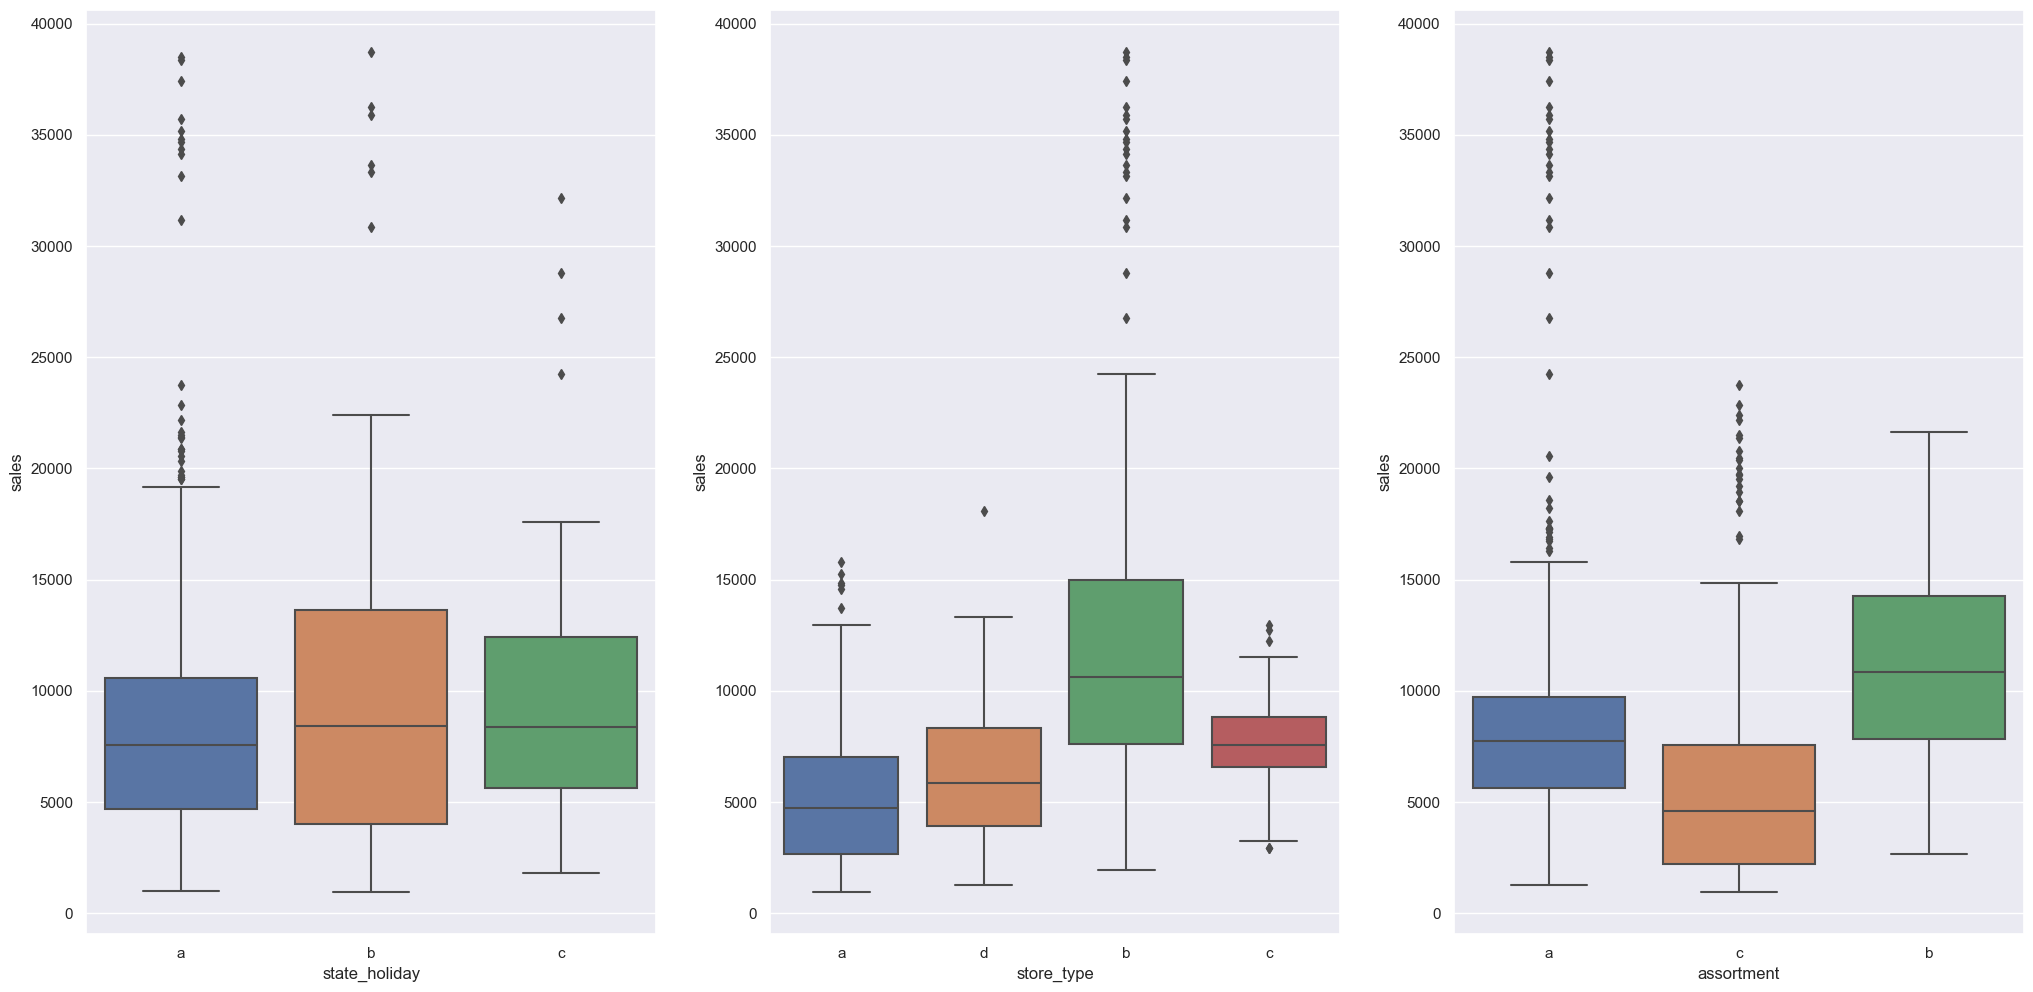

In [20]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. Feature Engineering

In [21]:
df2 = df1.copy()

In [22]:
df2['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

## 2.1. Mapa Mental de Hipoteses

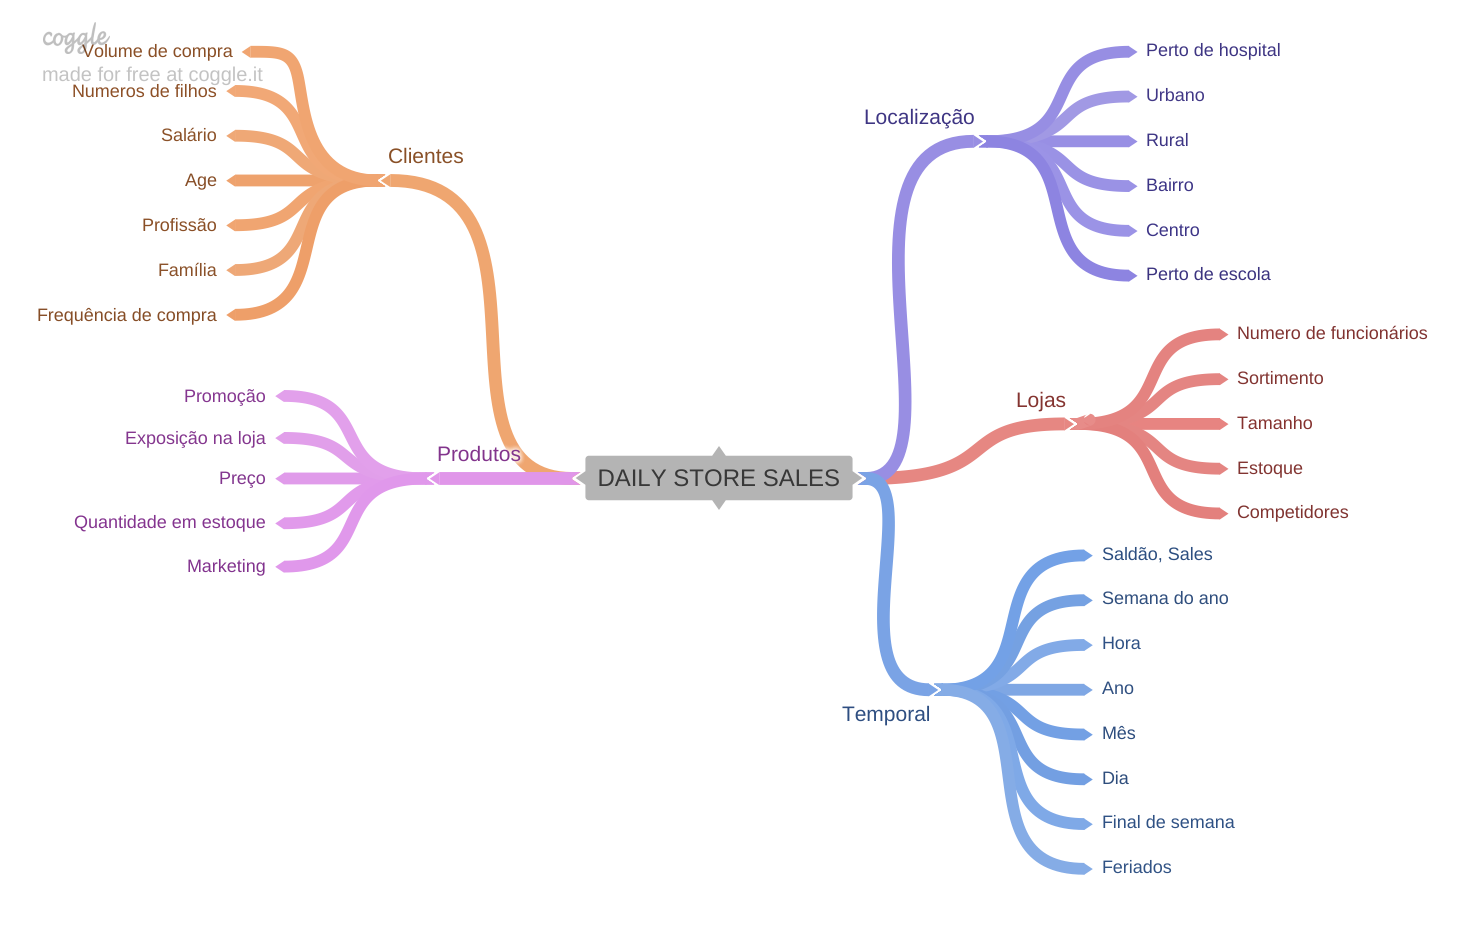

In [23]:
Image( 'C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\MindMapHypothesis.png')

## 2.2. Criação de Hipoteses

## 2.3. Lista Final de Hipoteses

## 2.4. Feature Engineering

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month

df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
#df2['week_of_year'] = df2['date'].dt.weekofyear
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )



# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
#df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply (lambda x: x.days).astype(int)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply (lambda x: x.days).astype(int)

# promo since
# Sanar dúvidas####
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)







In [25]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day')


In [26]:
df2['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Filtragem de variáveis

In [28]:
df3 = df2.copy()

In [29]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das linhas

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales']>0)]

## 3.2. Seleção das colunas

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. Análise exploratória dos dados

In [32]:
df4 = df3.copy()

In [33]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

## 4.1. Análise univariada

### 4.1.1. Response Variable

C:\Users\nerod\AppData\Local\Temp\ipykernel_18188\1473926699.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4['sales'])


<Axes: xlabel='sales', ylabel='Density'>

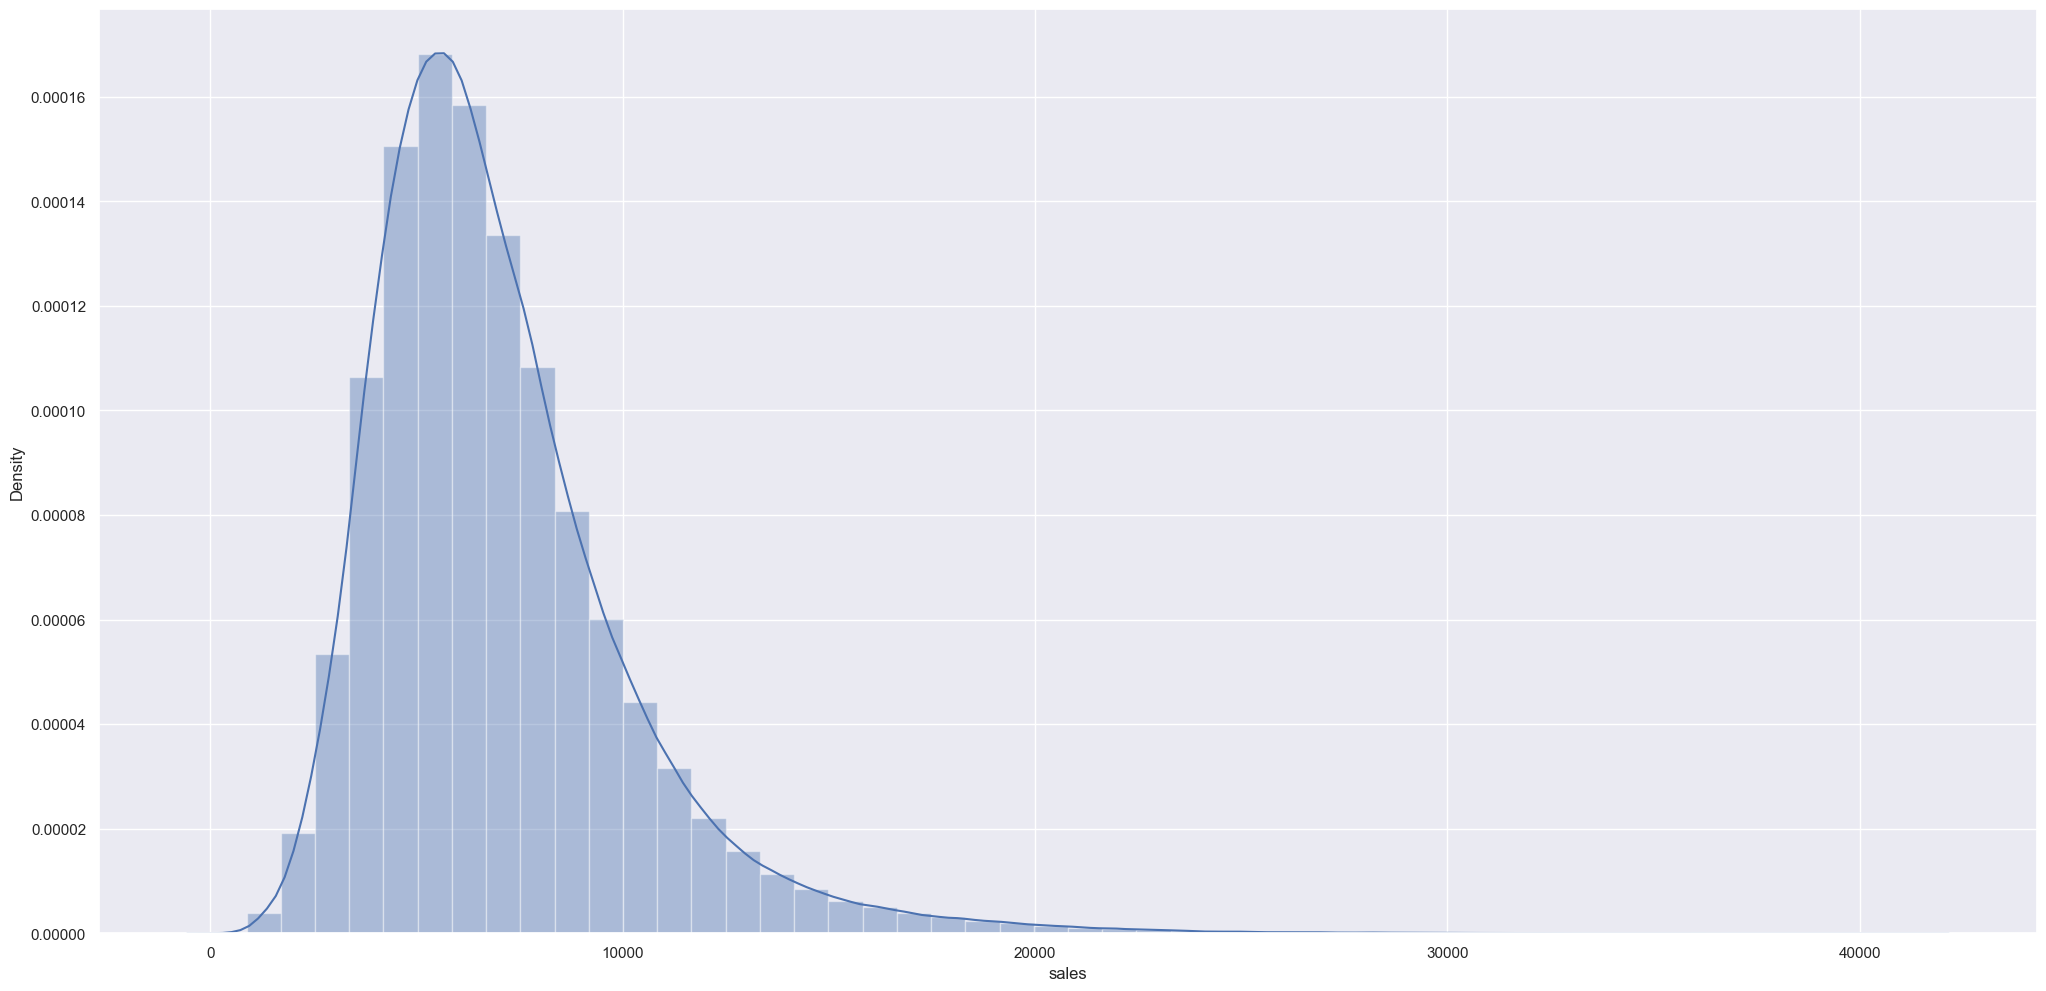

In [34]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

In [ ]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

C:\Users\nerod\AppData\Local\Temp\ipykernel_18188\1173682749.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
C:\Users\nerod\AppData\Local\Temp\ipykernel_18188\1173682749.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
C:\Users\nerod\AppData\Local\Temp\ipykernel_18188\1173682749.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)
C:\Users\nerod\AppData\

<Axes: xlabel='sales', ylabel='Density'>

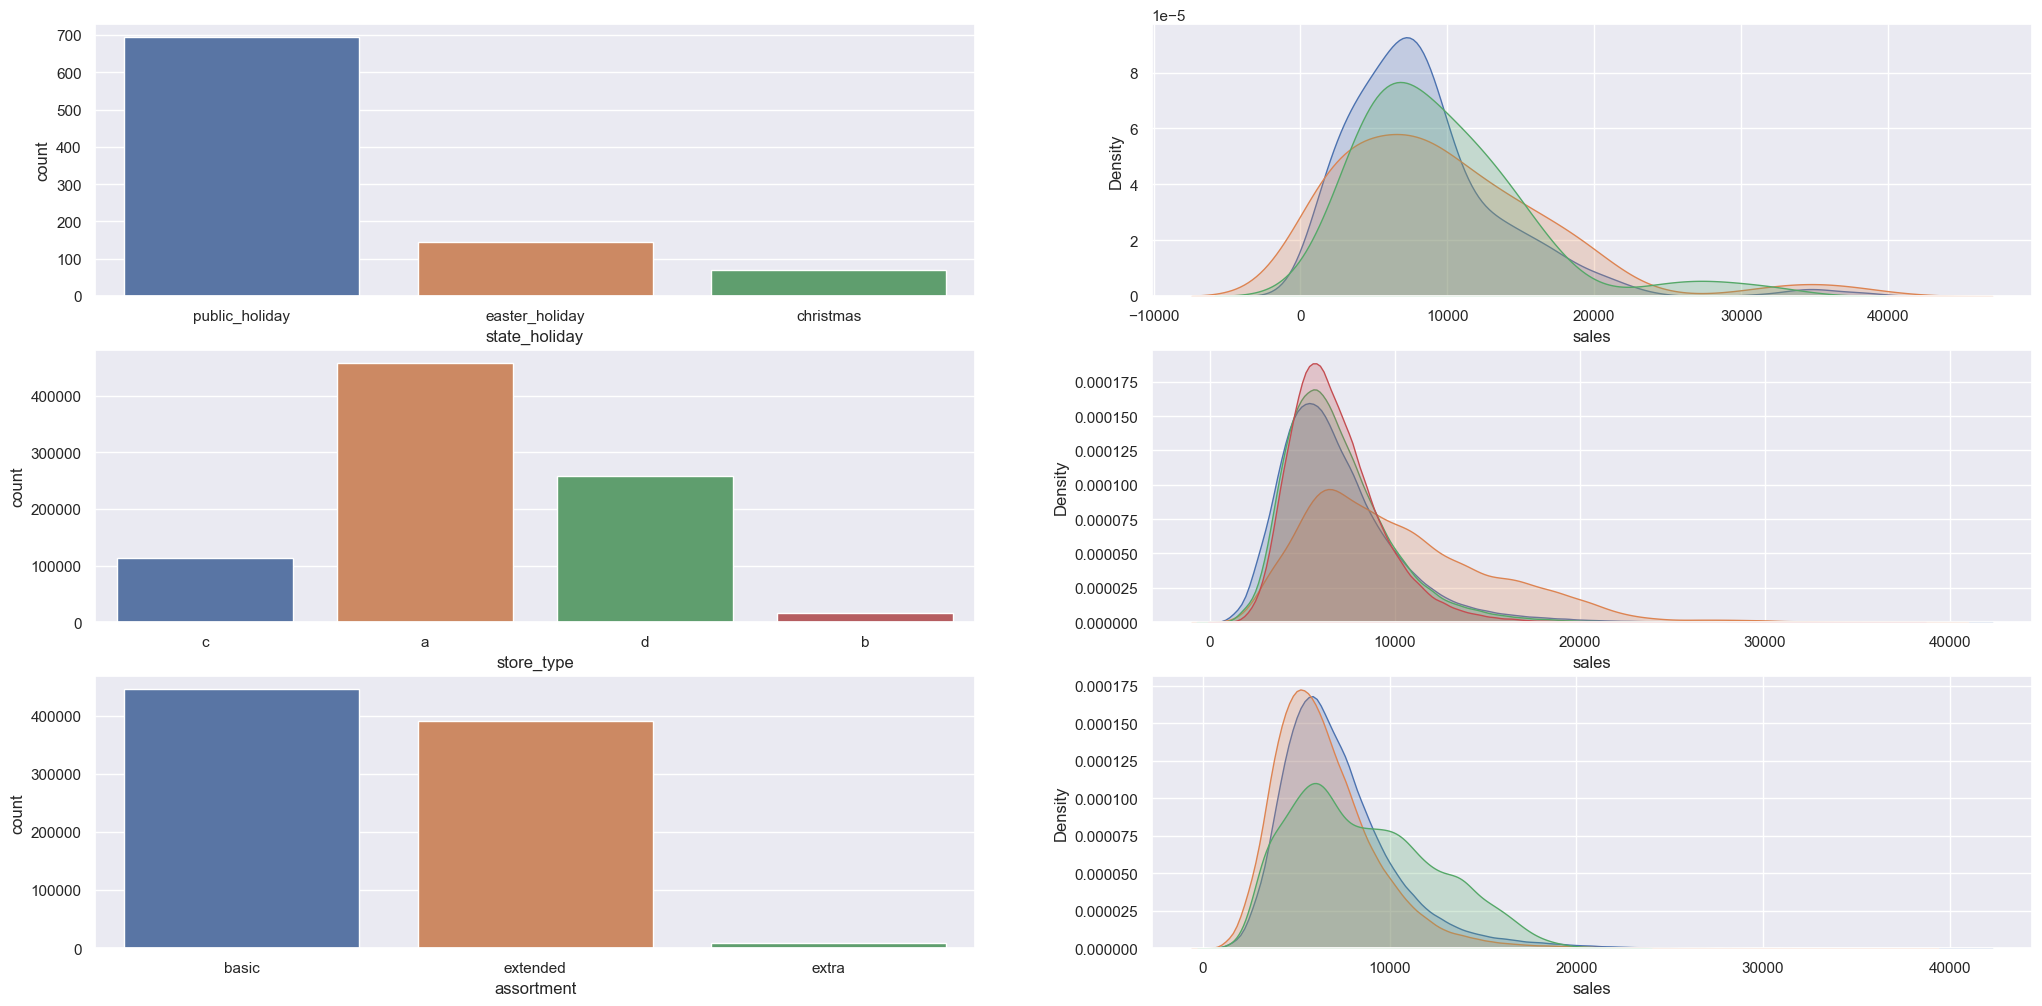

In [35]:
a = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(3, 2, 1)
sns.countplot(data=a, x='state_holiday')

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


plt.subplot(3, 2, 3)
sns.countplot(data=df4, x='store_type')

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)


plt.subplot(3, 2, 5)
sns.countplot(data=df4, x='assortment')

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='c', shade=True)


## 4.2. Análise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.
***Falsa*** Lojas com maior sortimento vendem menos.

<AxesSubplot:xlabel='year_week'>

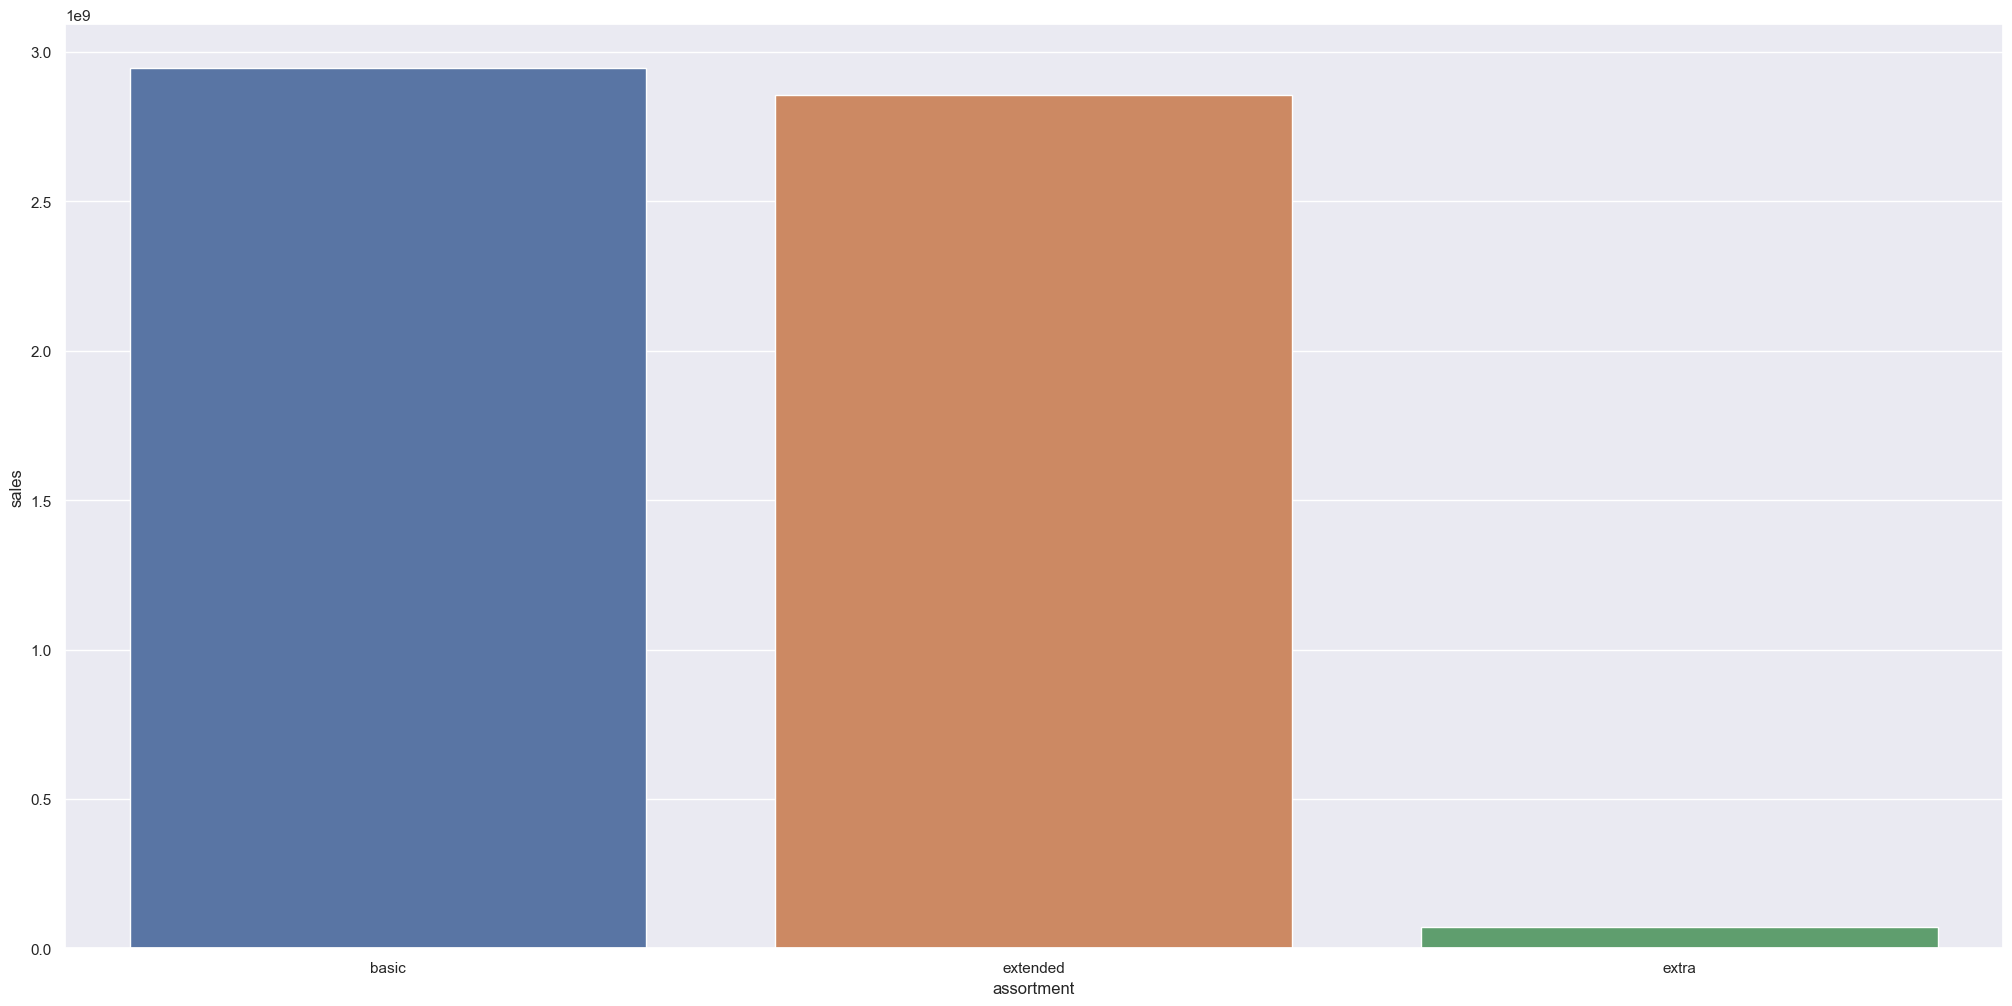

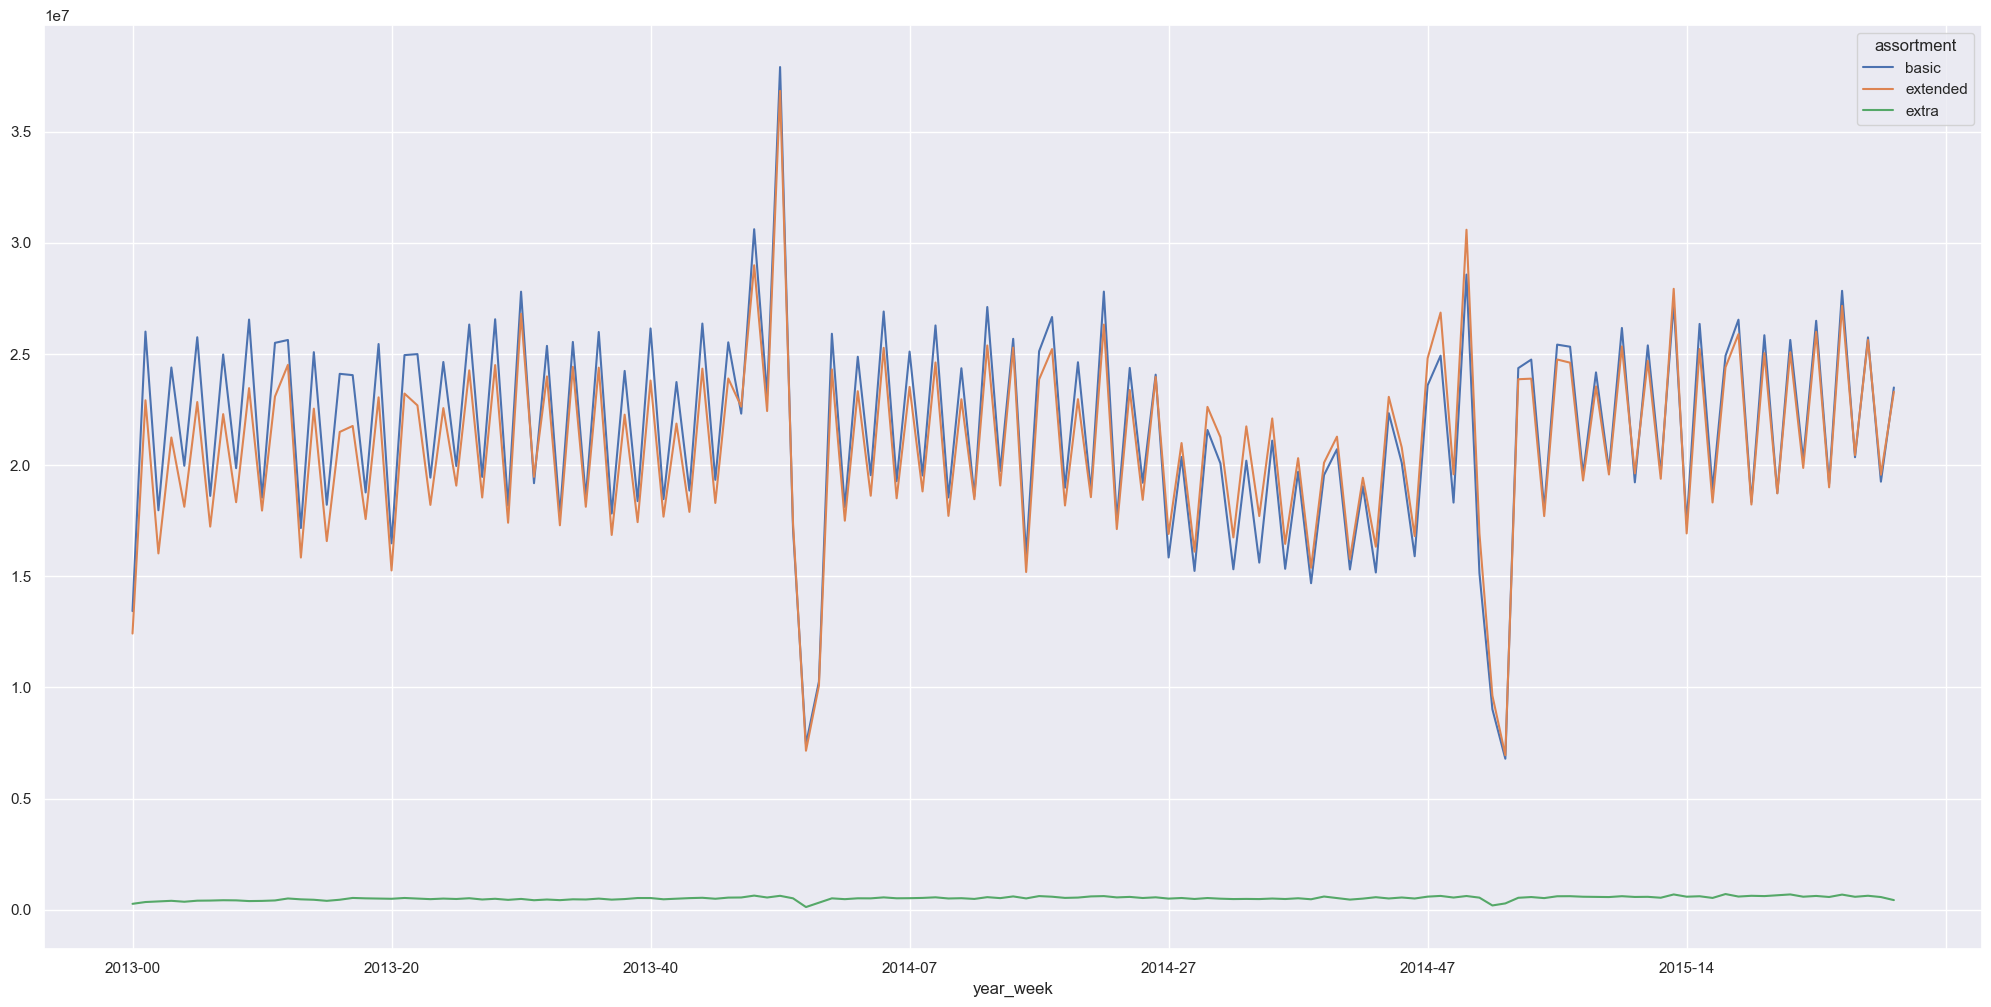

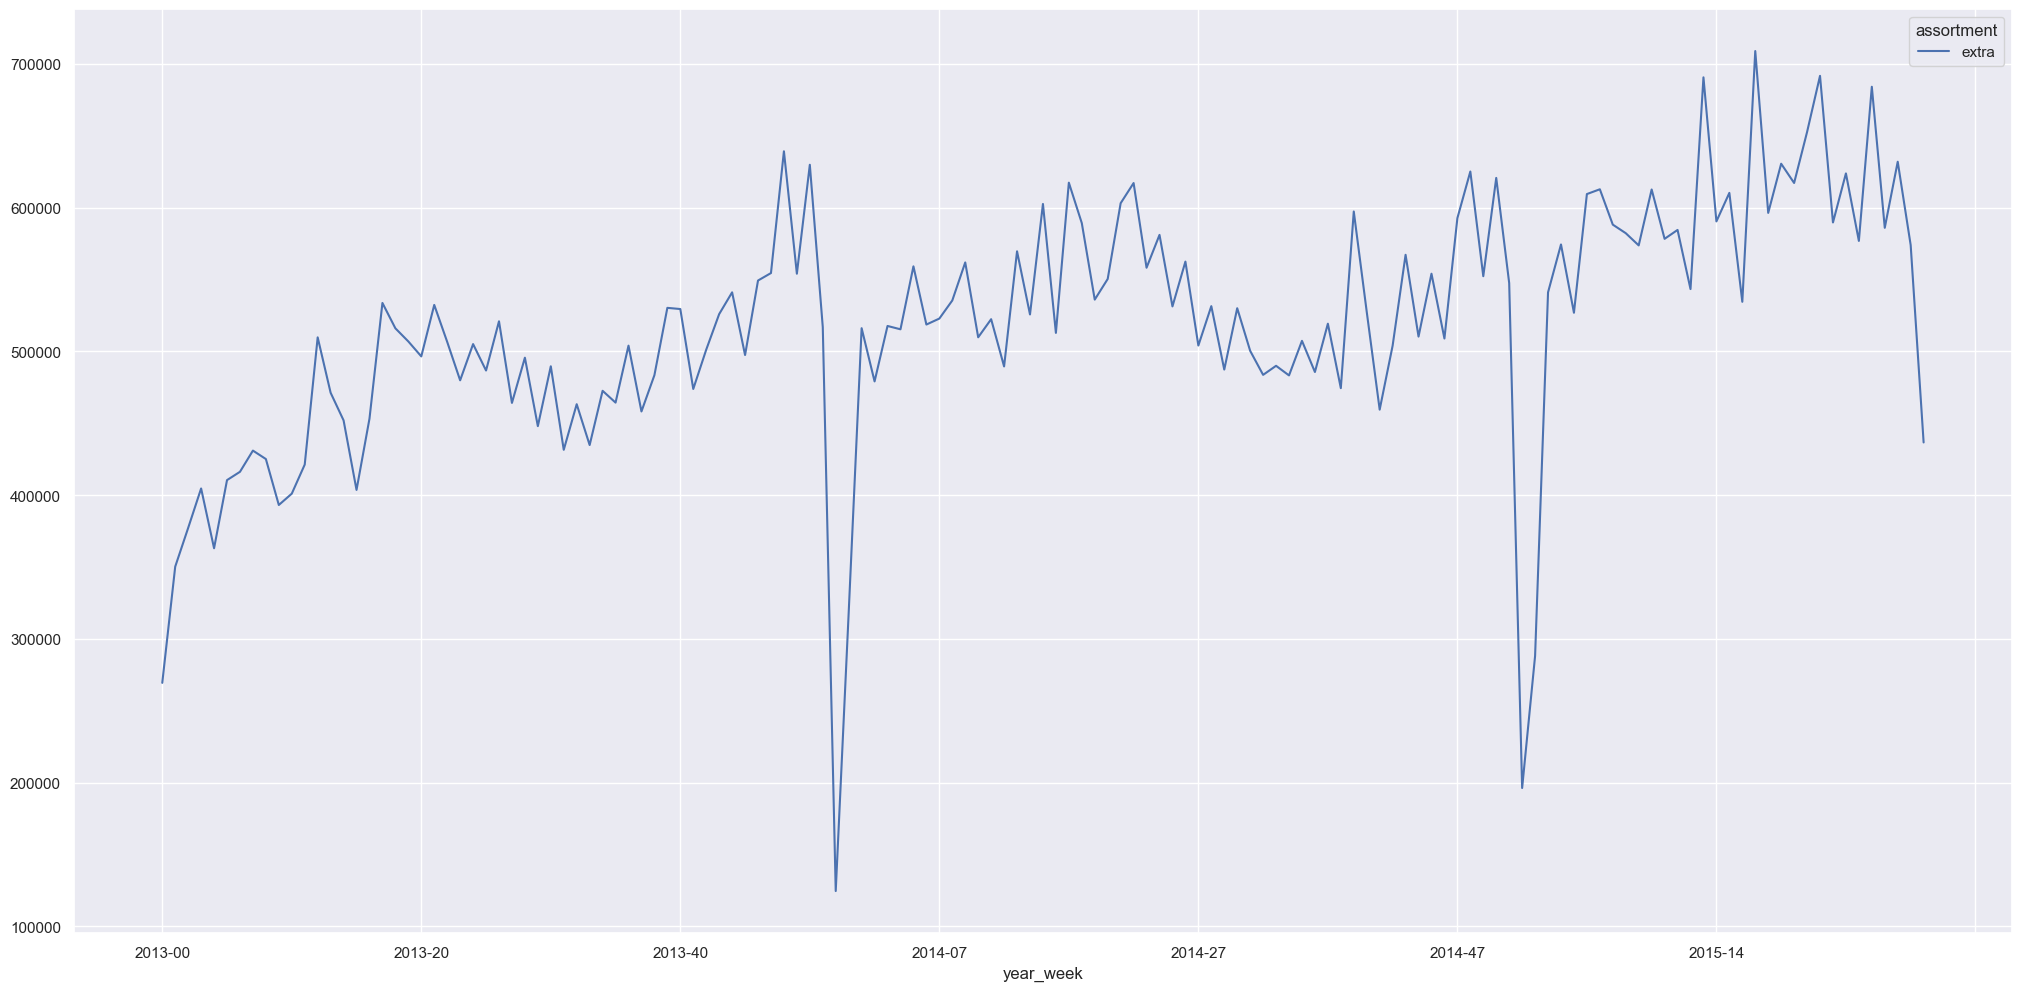

In [38]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


### H2. Lojas com competidores mais próximos deveriam vender menos.
 ***Falsa*** Lojas com competidores mais próximos vendem mais.

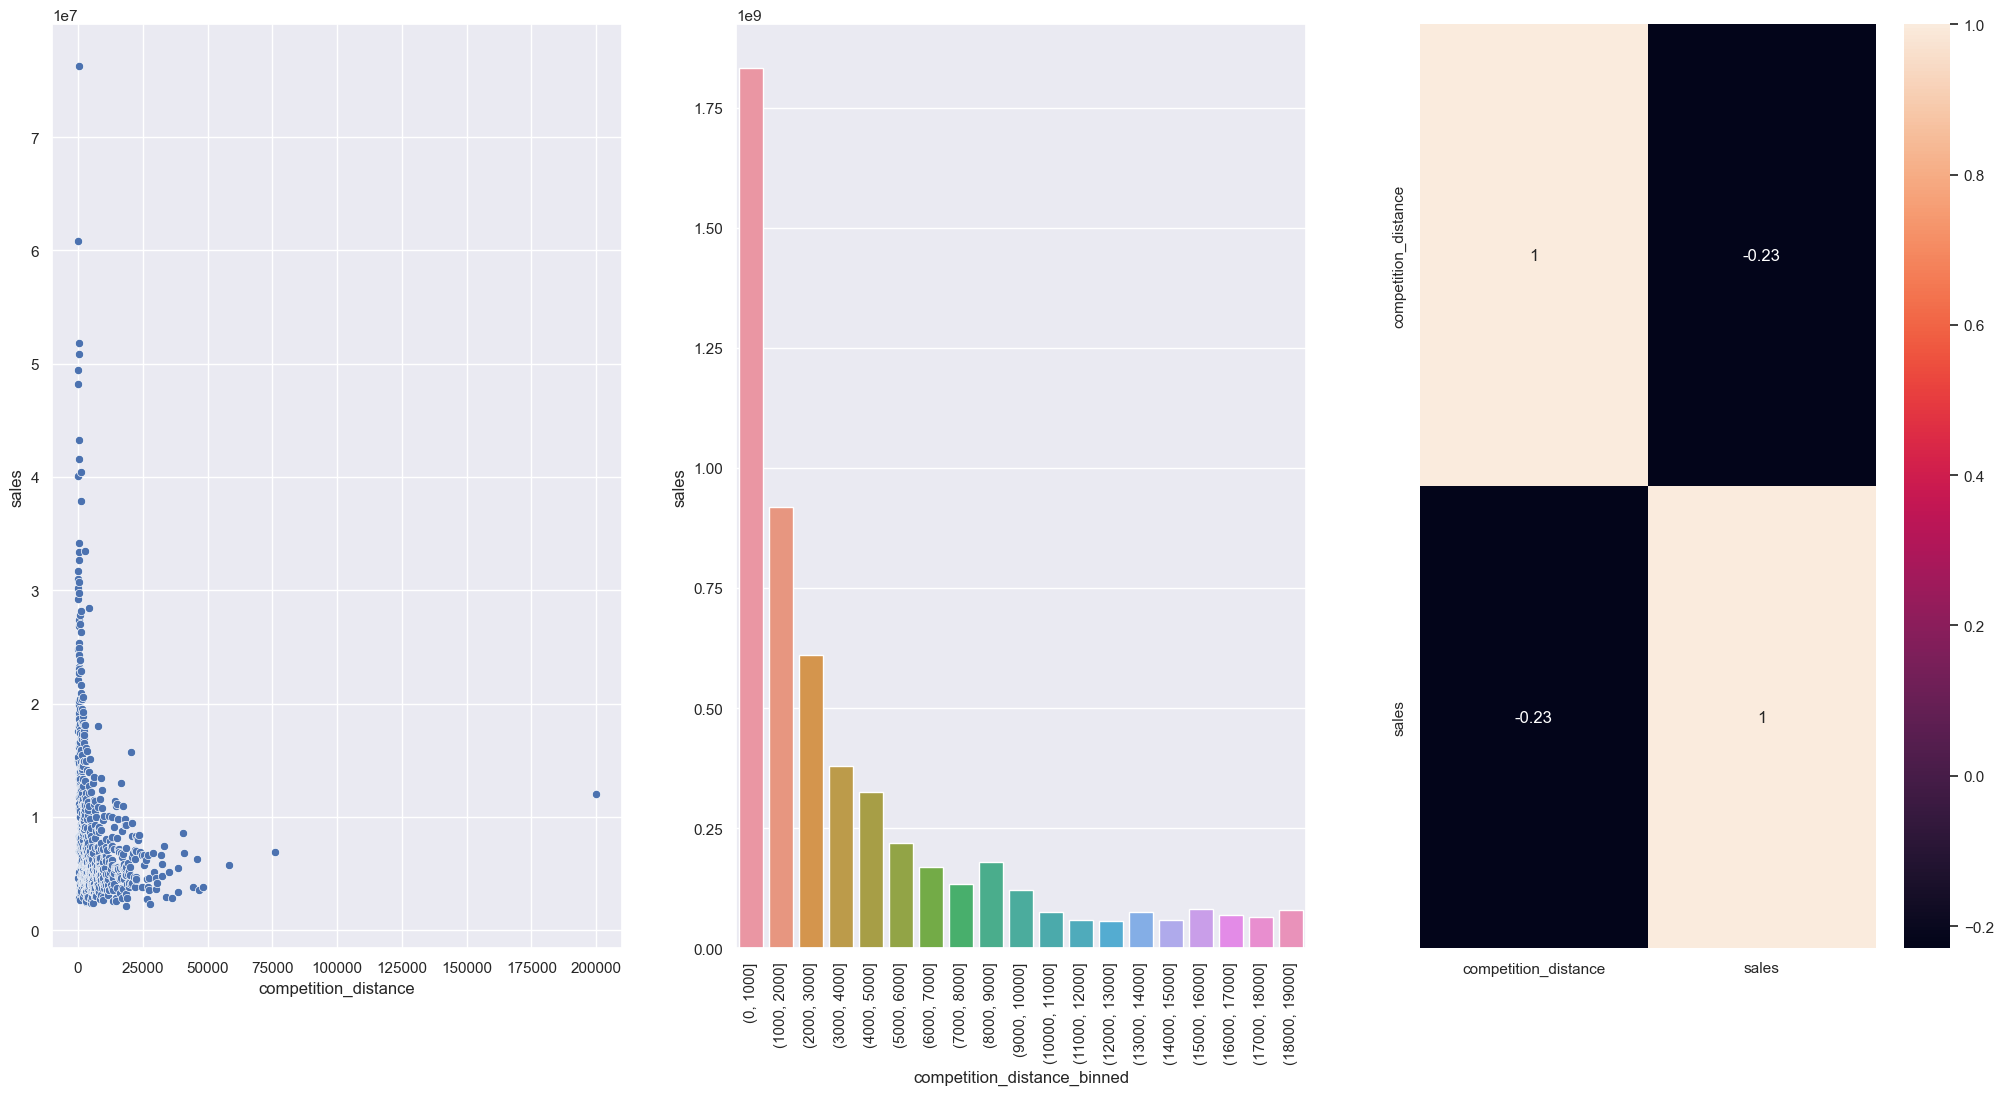

In [39]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
bins= list(np.arange(0, 20000, 1000))

plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data=aux1)

plt.subplot(1, 3, 2)
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90);


### Correlação de person
plt.subplot(1, 3, 3)
x = sns.heatmap( aux1.corr(method='pearson'), annot=True);



### H3. Lojas com competidores à mais tempo devem vender mais.
***False*** Lojas com competidores à mais tempo vendem menos.

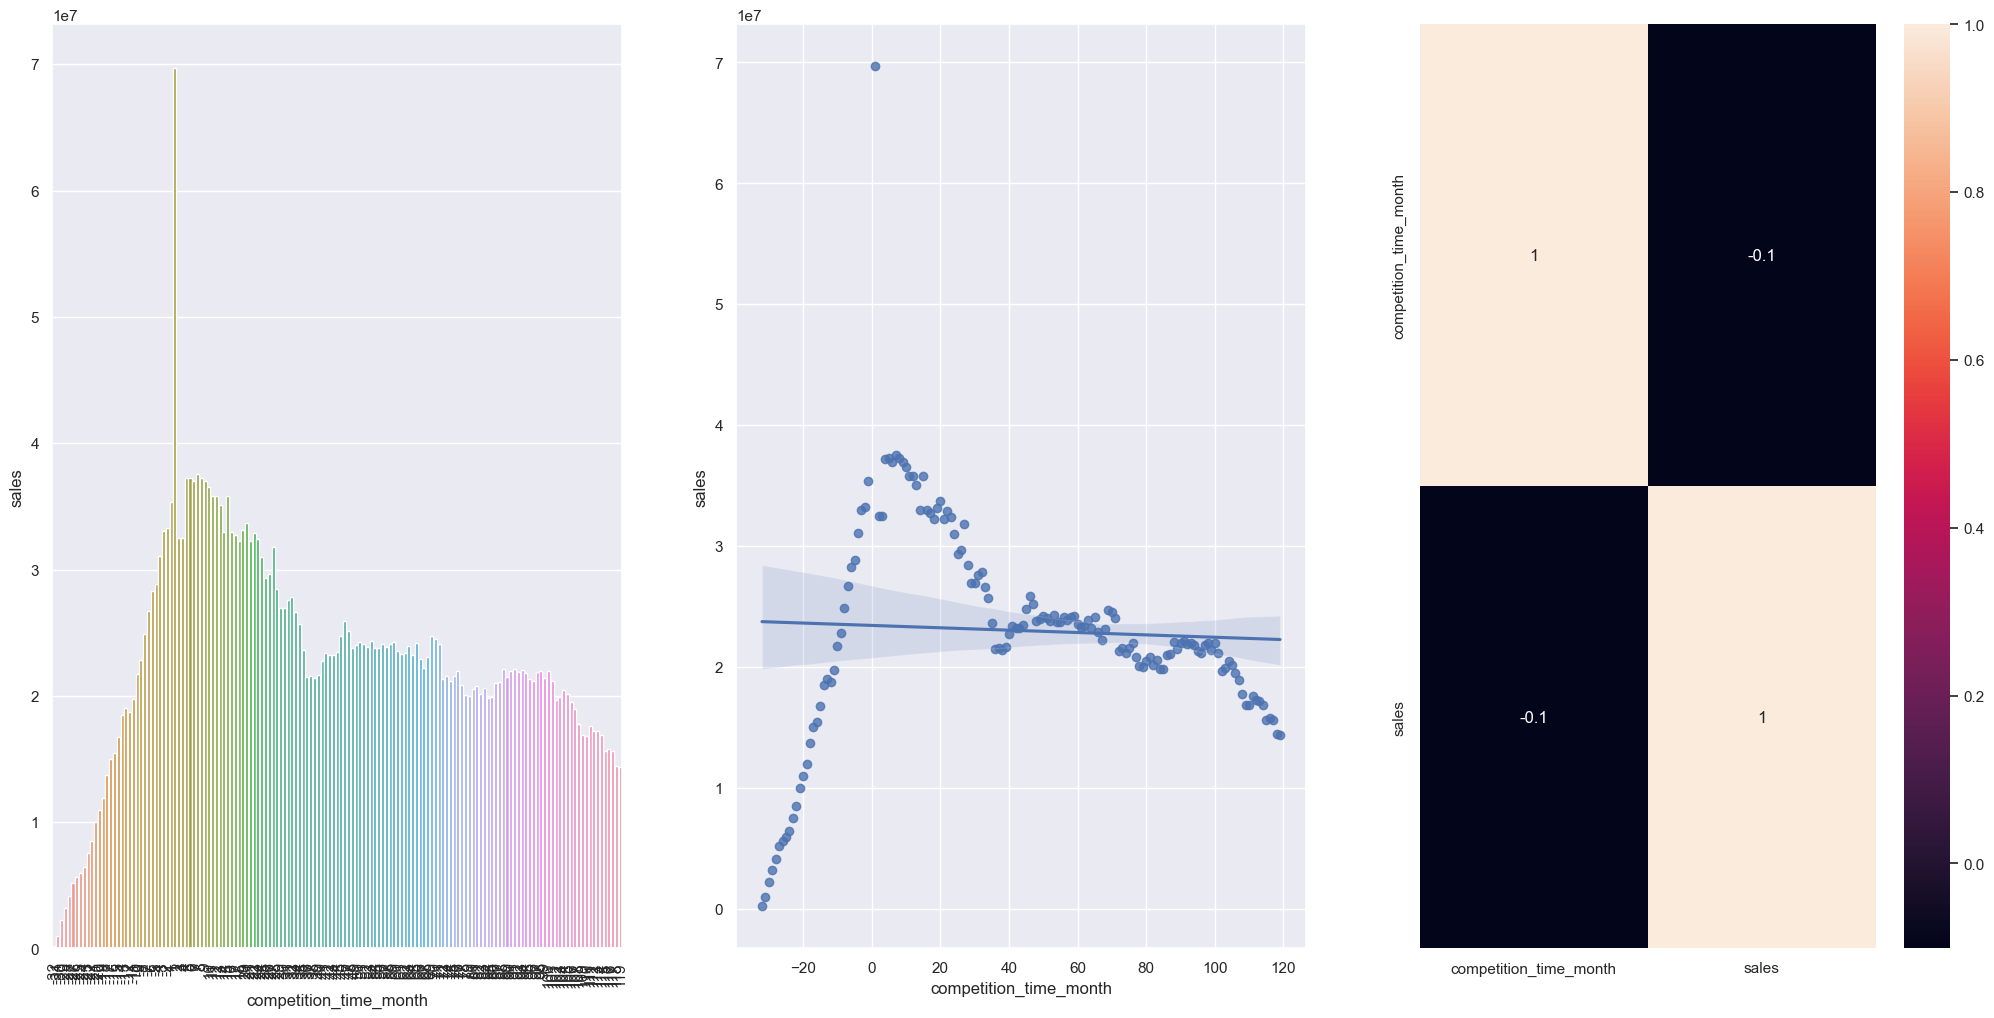

In [40]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
x = sns.heatmap( aux1.corr(method='pearson'), annot=True);


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
***Falsa*** Lojas com promoções ativas por mais tempo vendem menos, depois de um período de promoção.

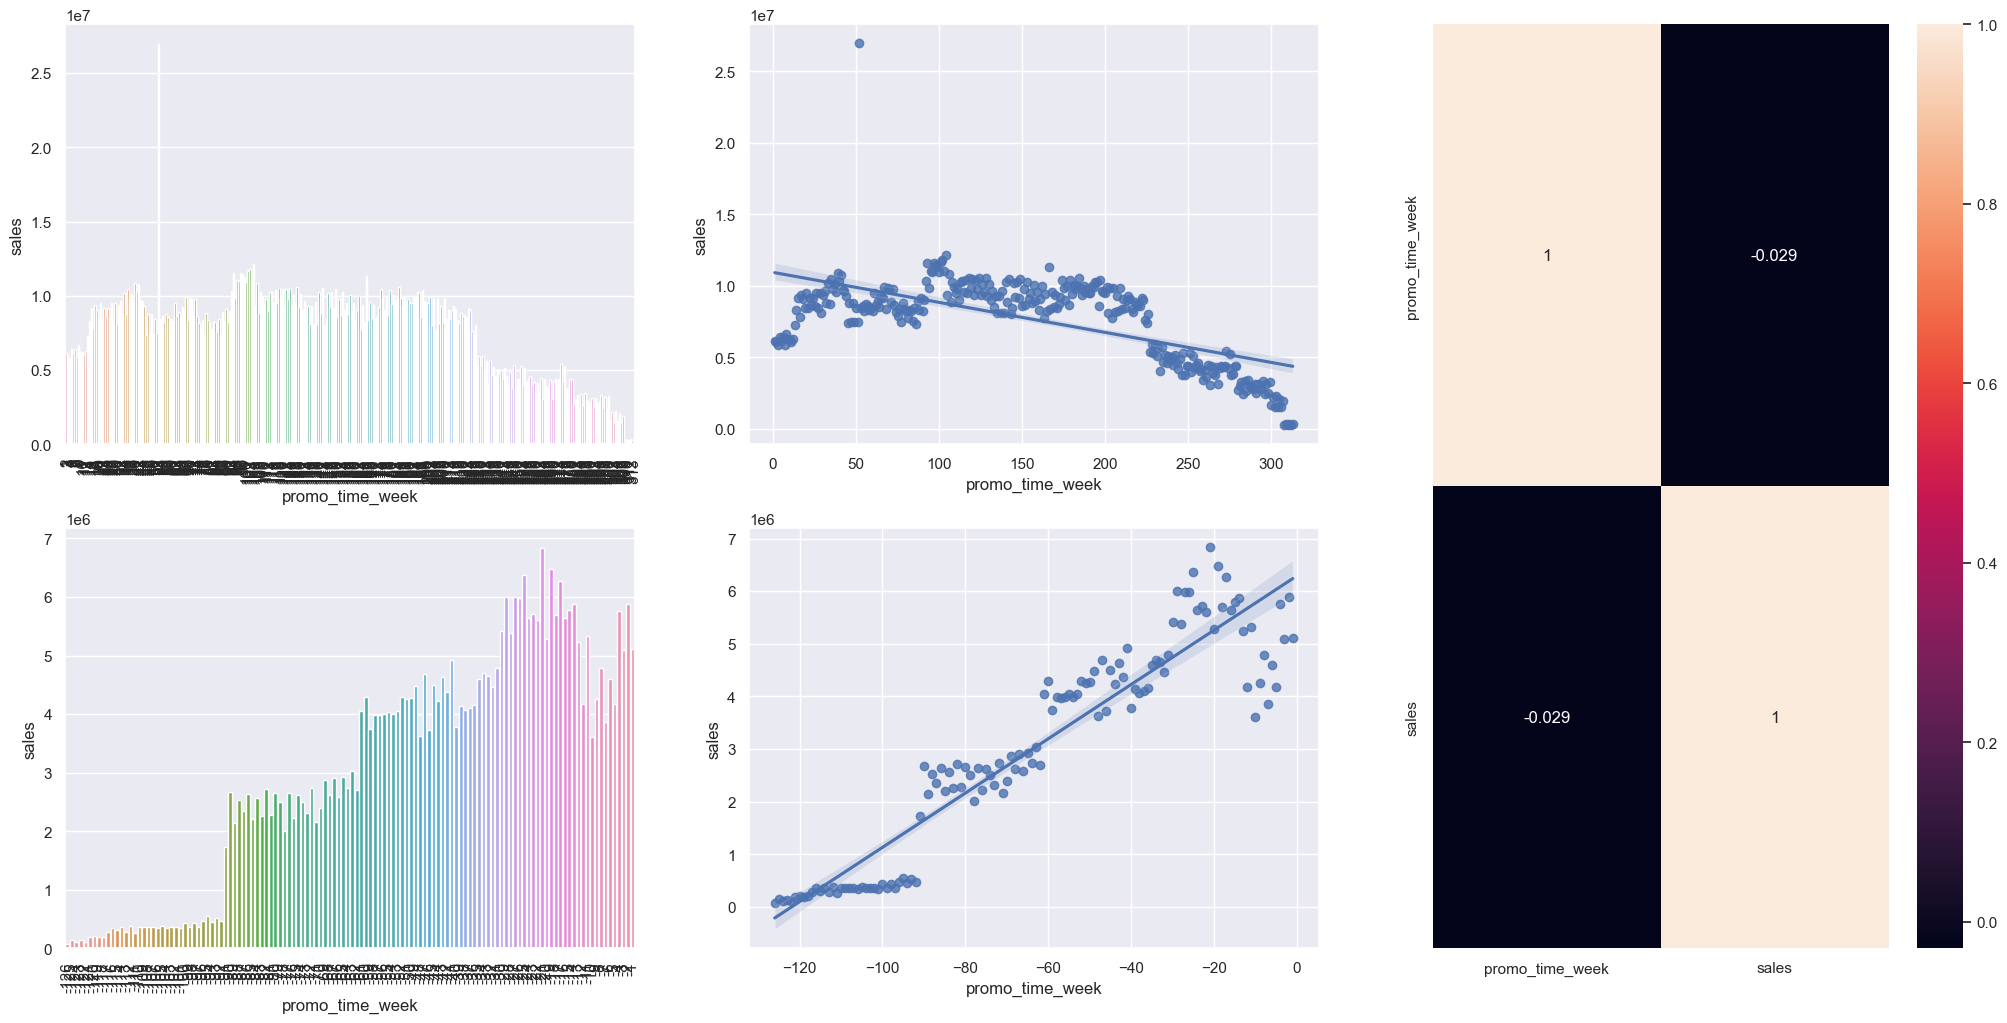

In [41]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2, 3)

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot( grid[0,1] )
sns.regplot(x='promo_time_week', y='sales', data=aux2);


plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks( rotation = 90);

plt.subplot( grid[1,1] )
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr(method='pearson'), annot=True );



### <s>H5. Lojas com mais dias de promoção deveriam vender mais</s>
***False***

### H6. Lojas com mais promoções consecutivas deveriam vender mais.
***False*** Lojas com promoções consecutivas vendem menos

In [42]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


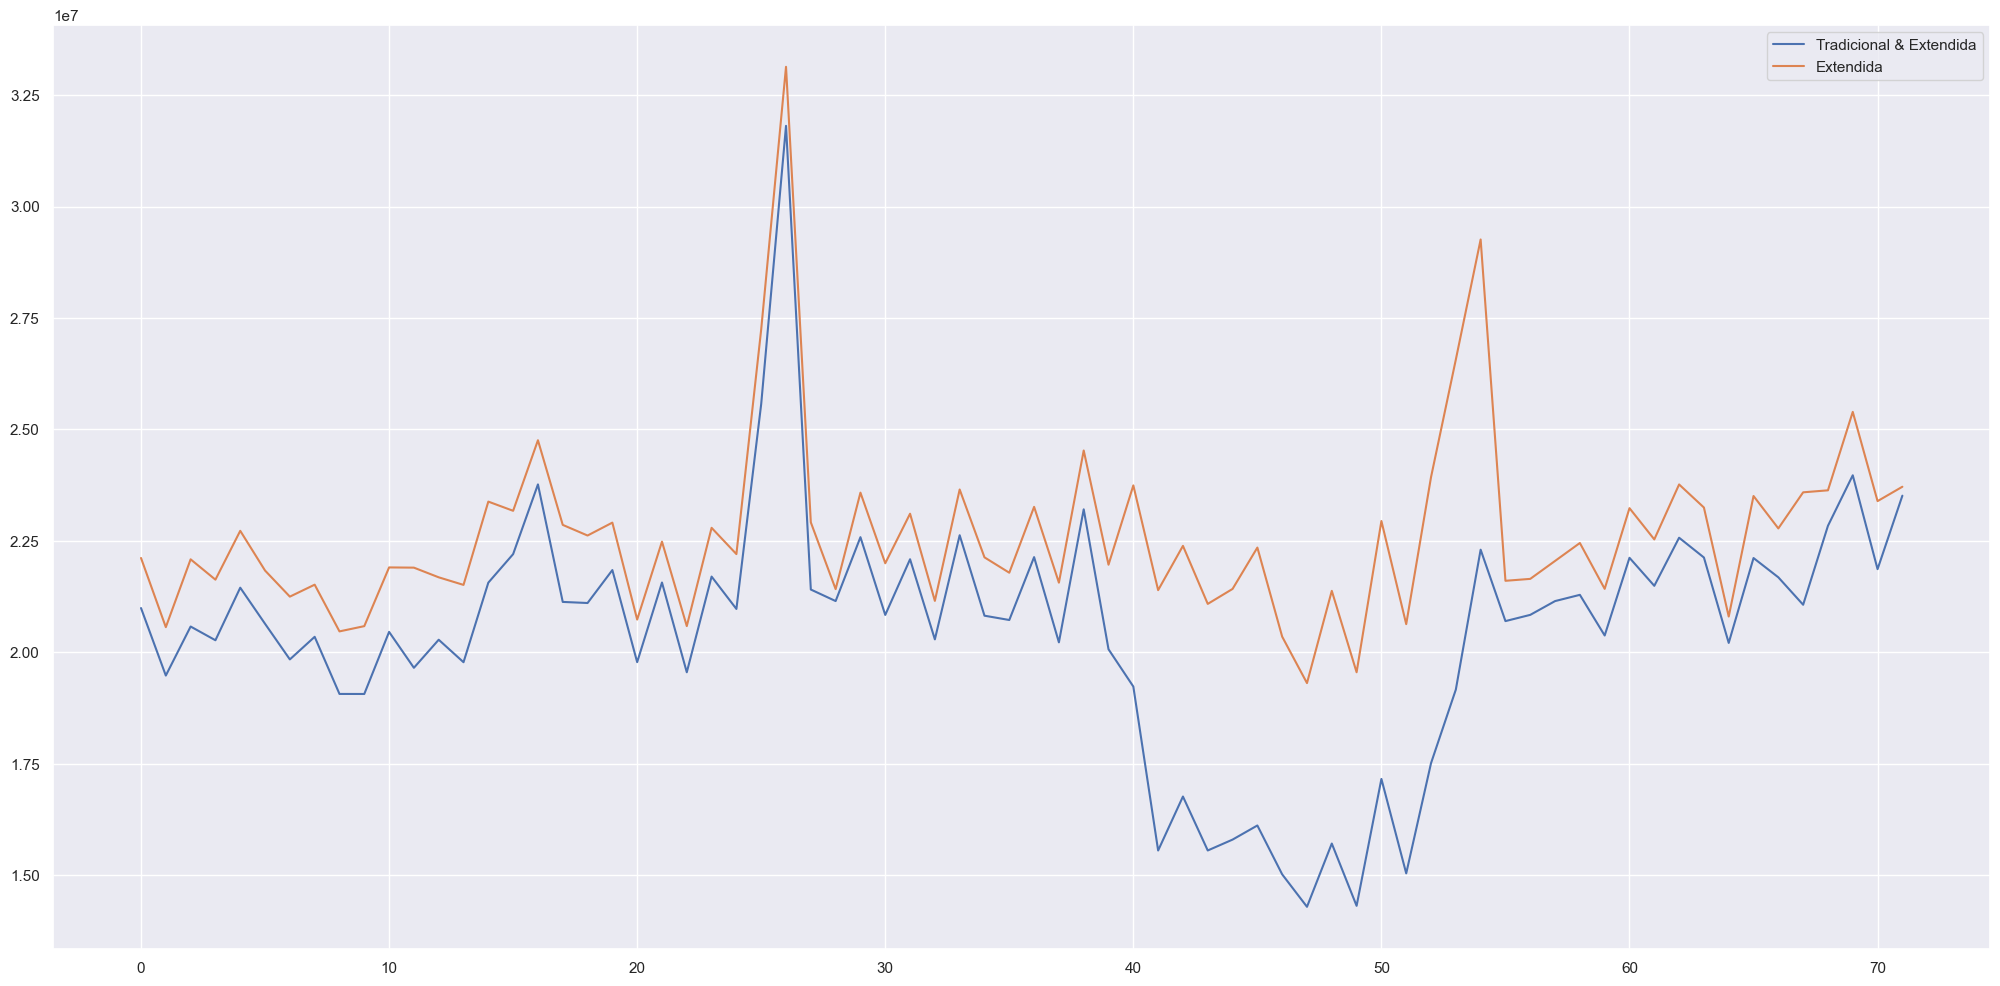

In [43]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
***False*** Lojas abertas no feriado de natal vendem menos

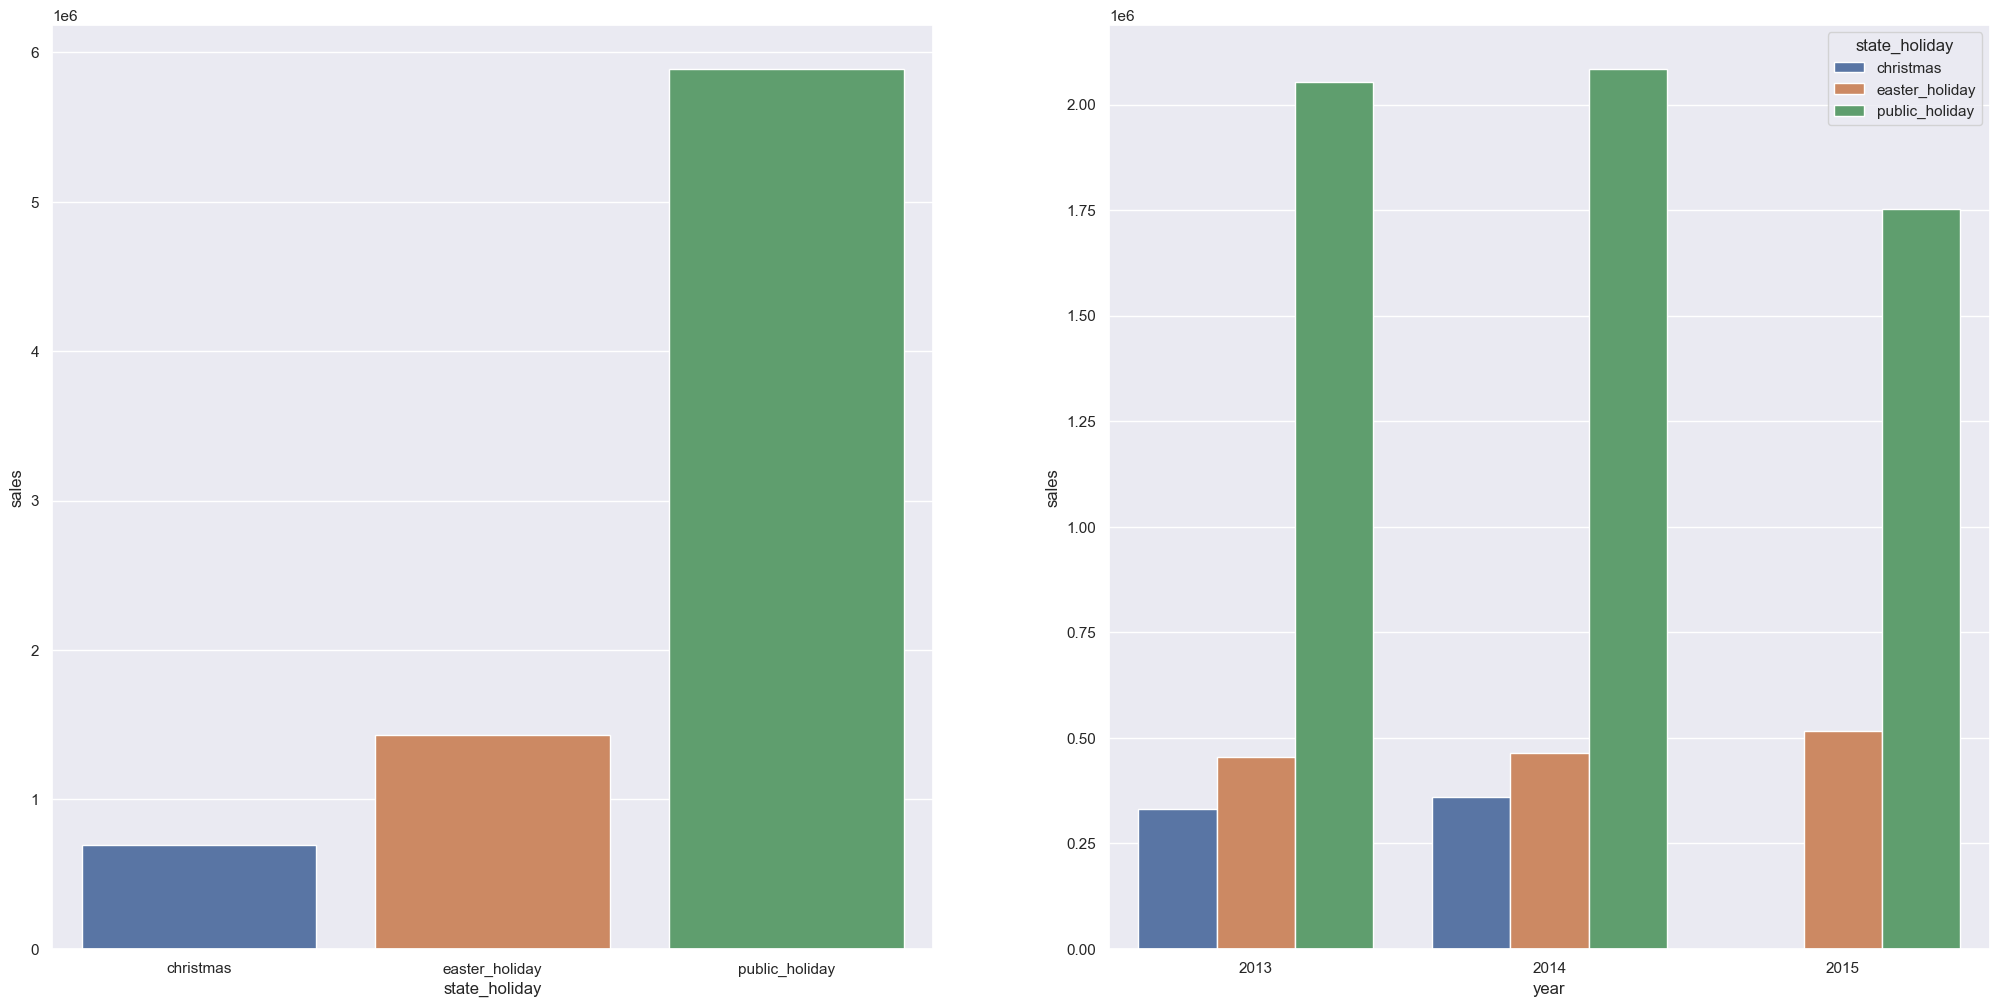

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H8. Lojas deveriam vender mais ao longo dos anos.
***False*** Lojas vendem menos ao longo dos anos

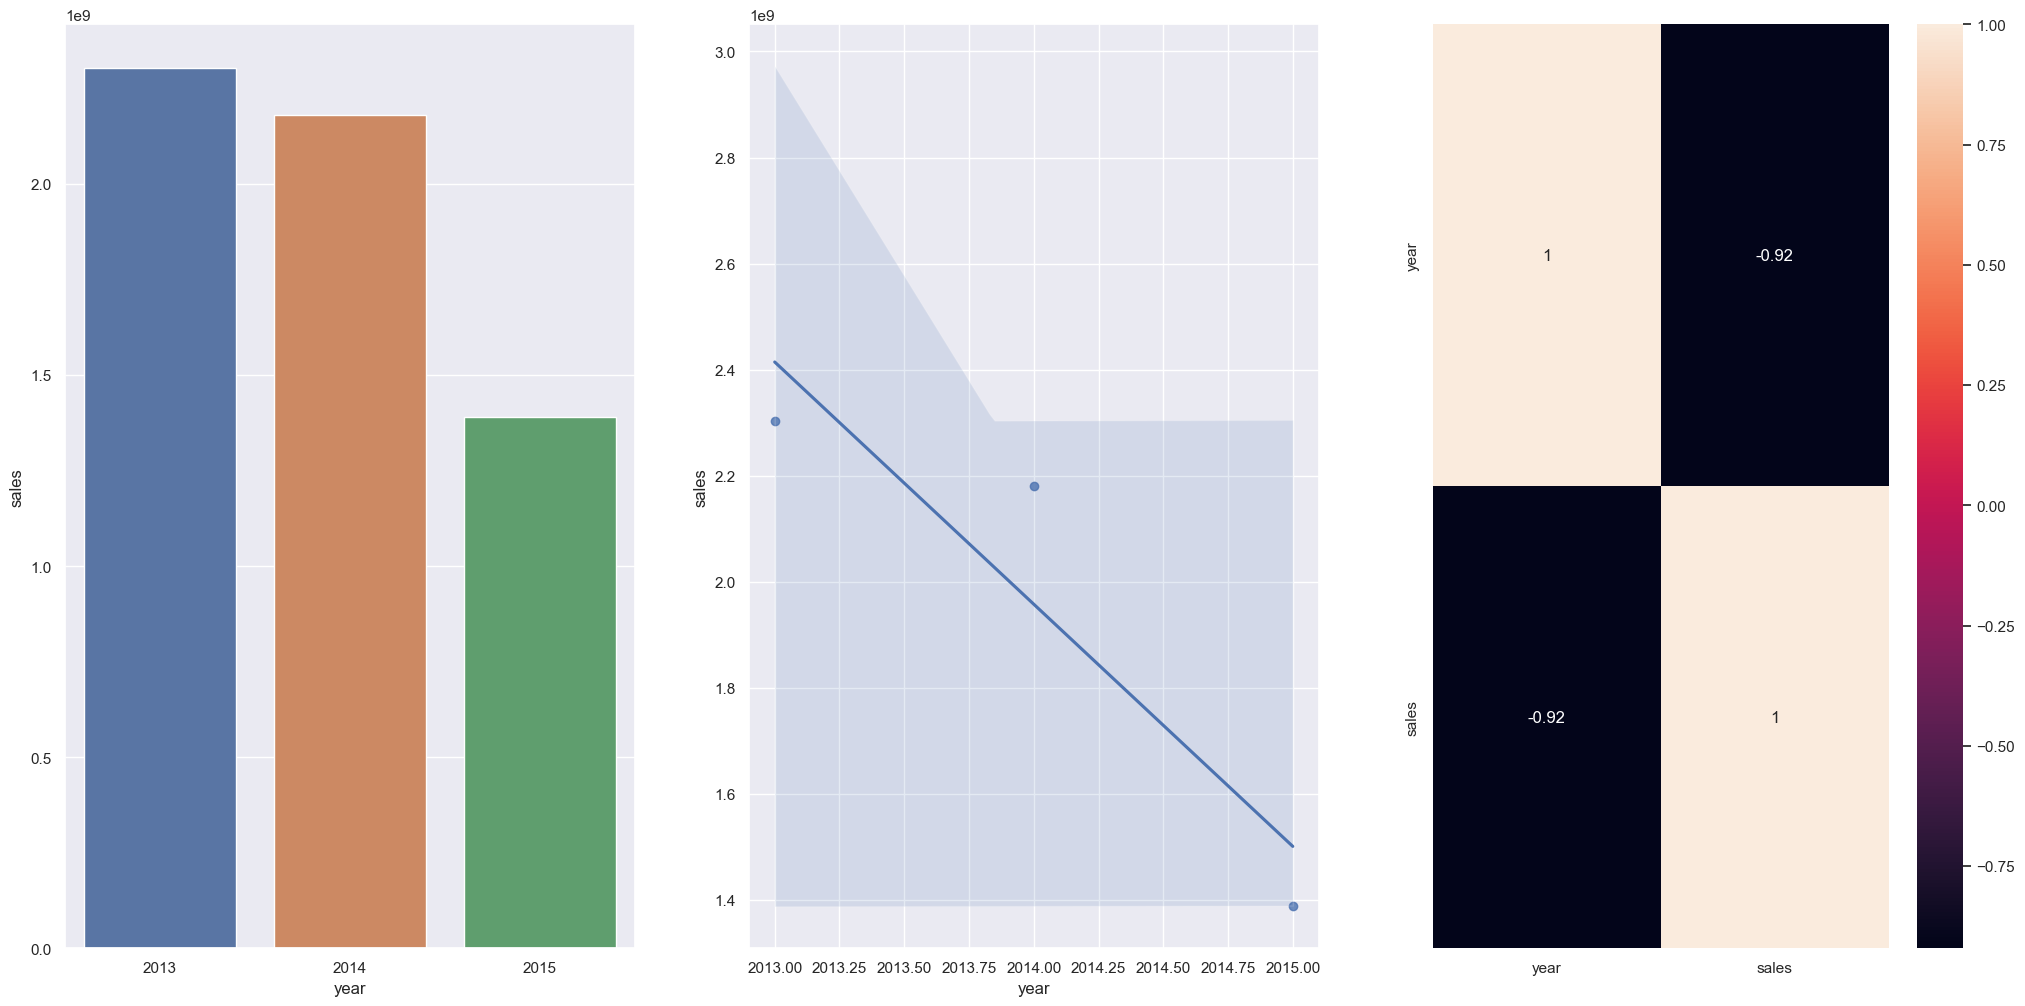

In [45]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot( x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H9. Lojas deveriam vender mais no segundo semestre do ano.
***Falsa*** Lojas vendem menos no segundo semestre do ano

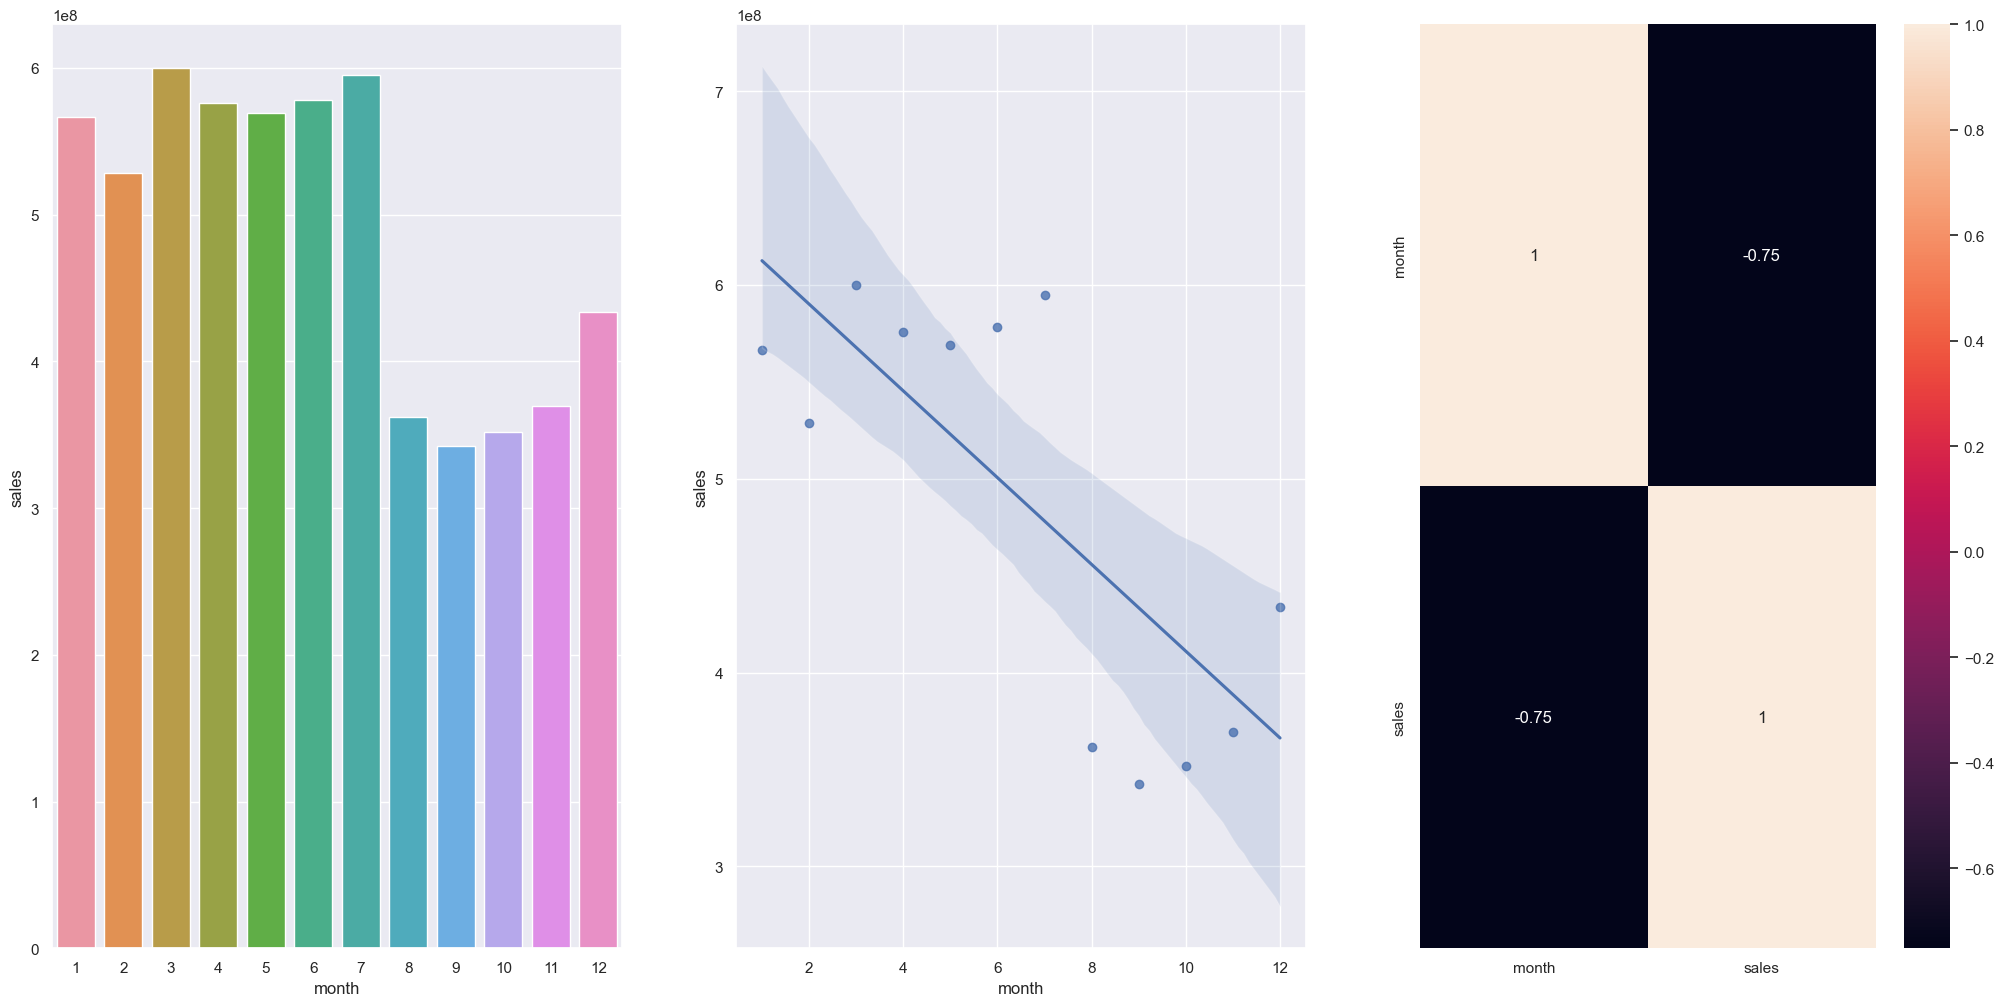

In [46]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot( x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
***Verdadeira*** Lojas vendem mais depois do dia 10 de cada mês.

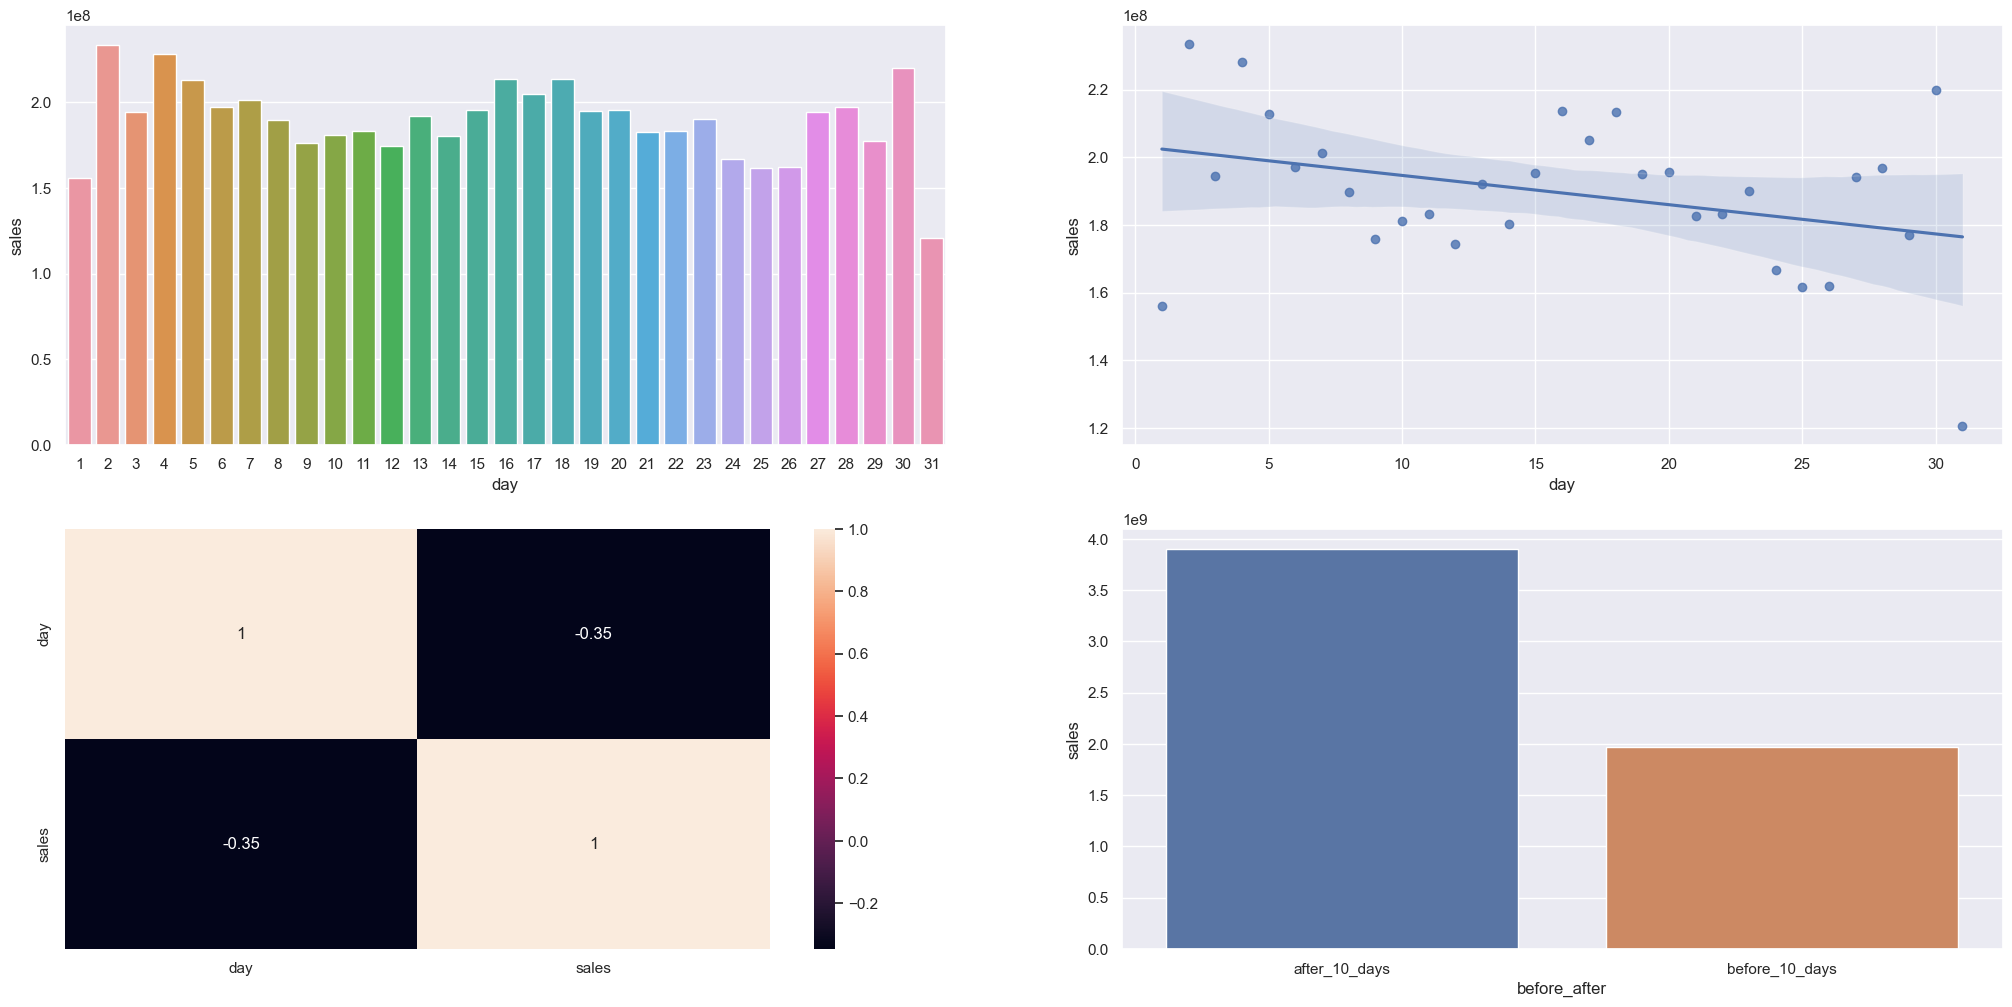

In [47]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot( x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot( x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot( x='before_after', y='sales', data=aux2);

### H11. Lojas deveriam vender menos aos finais de semana.
***Verdadeira*** Lojas vendem menos nos finais de semana.

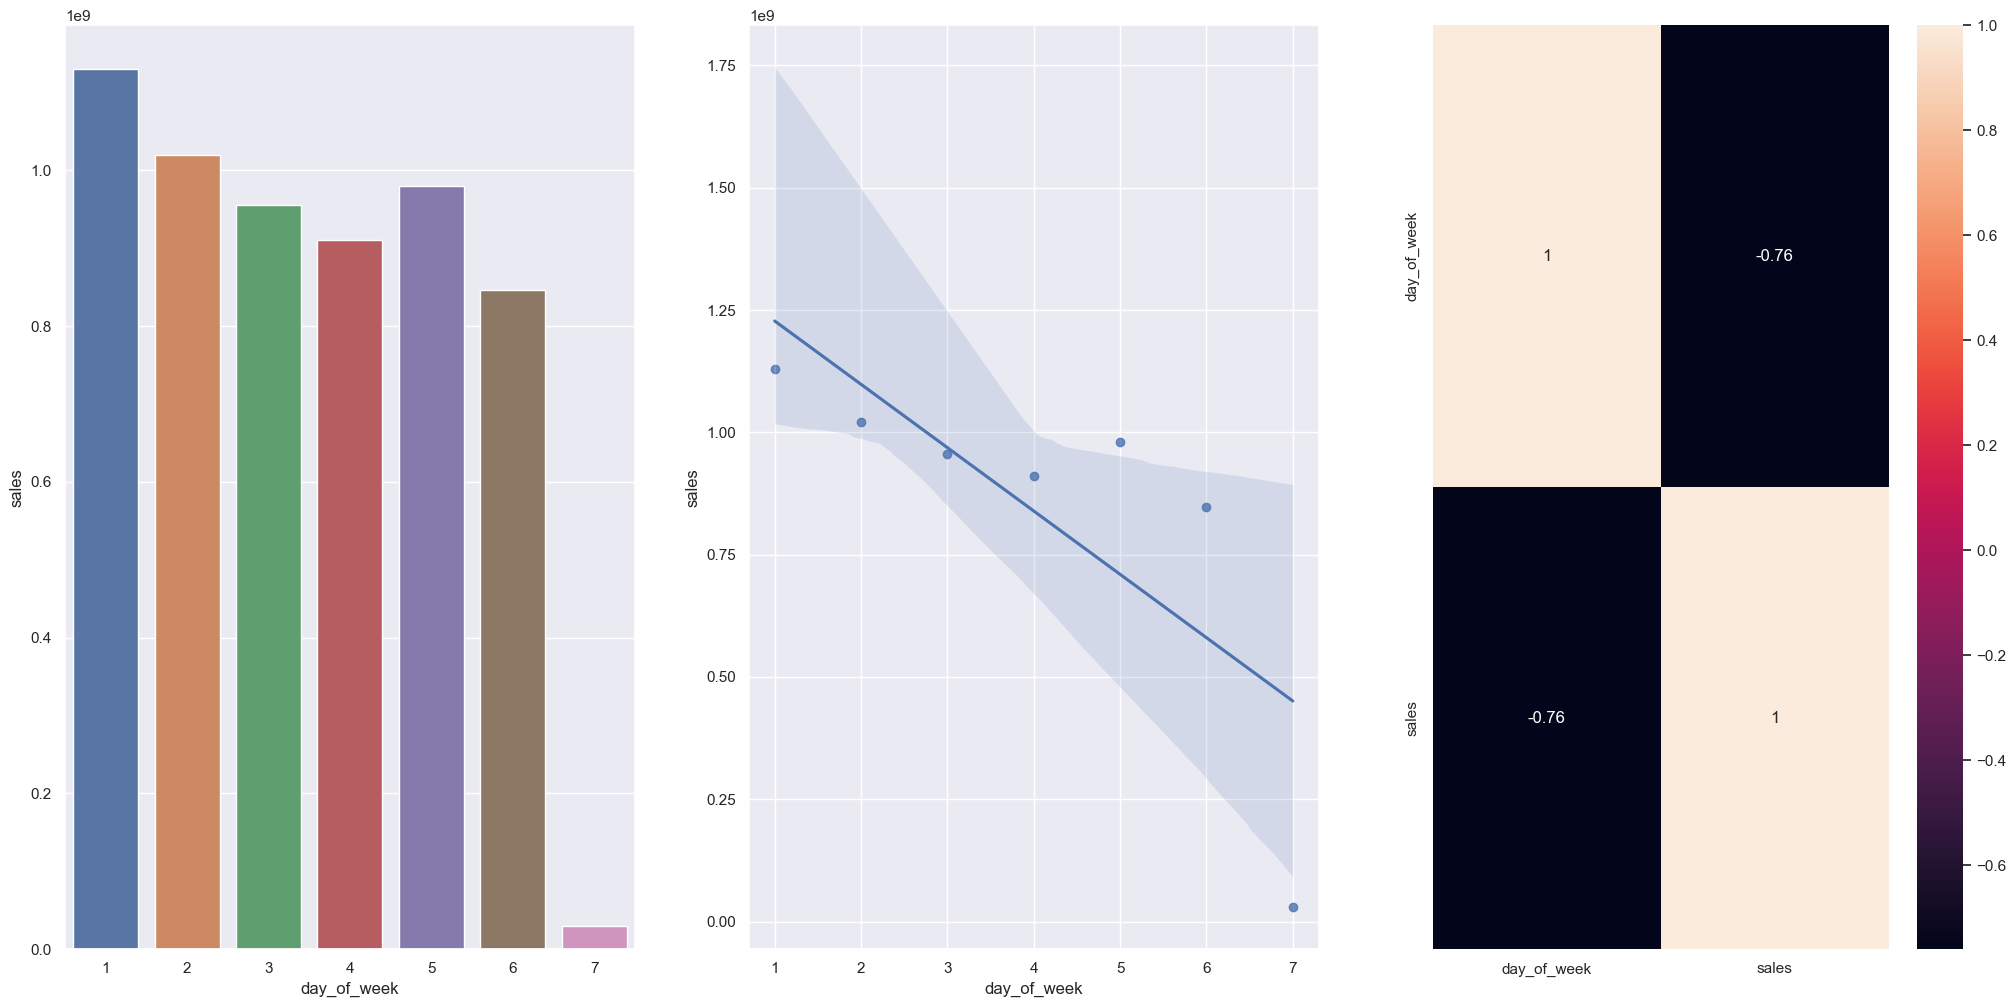

In [48]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot( x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot( x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H12. Lojas deveriam vender menos durante os feriados escolares.
***False*** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto.

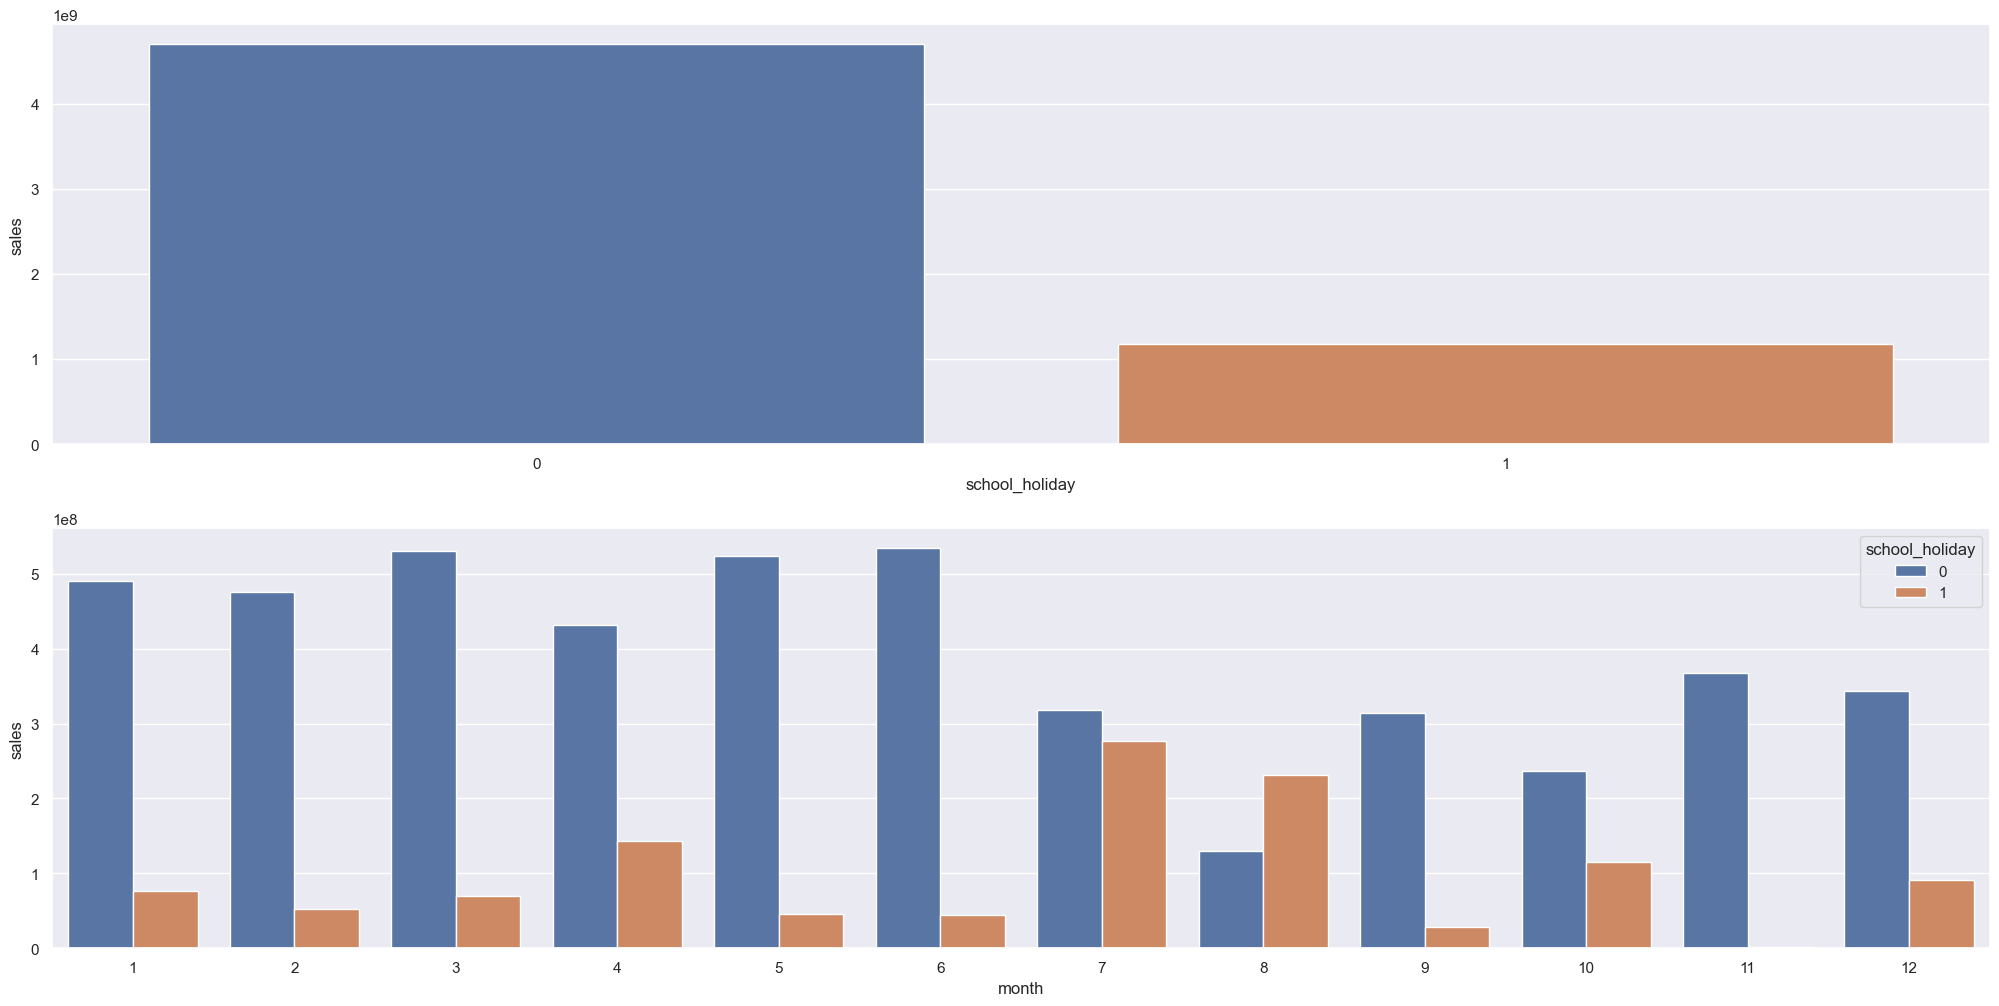

In [49]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales',hue='school_holiday', data=aux2);


### 4.2.1. Resumo das hipoteses

In [50]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
        ['H1', 'Falsa', 'Baixa'],
        ['H2', 'Falsa', 'Media'],
        ['H3', 'Falsa', 'Media'],
        ['H4', 'Falsa', 'Baixa'],
        ['H5', '-', '-'],
        ['H7', 'Falsa', 'Baixa'],
        ['H8', 'Falsa', 'Media'],
        ['H9', 'Falsa', 'Alta'],
        ['H10', 'Falsa', 'Alta'],
        ['H11', 'Verdadeira', 'Alta'],
        ['H12', 'Verdadeira', 'Alta'],
        ['H13', 'Verdadeira', 'Baixa']
       ]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Variable

<Axes: >

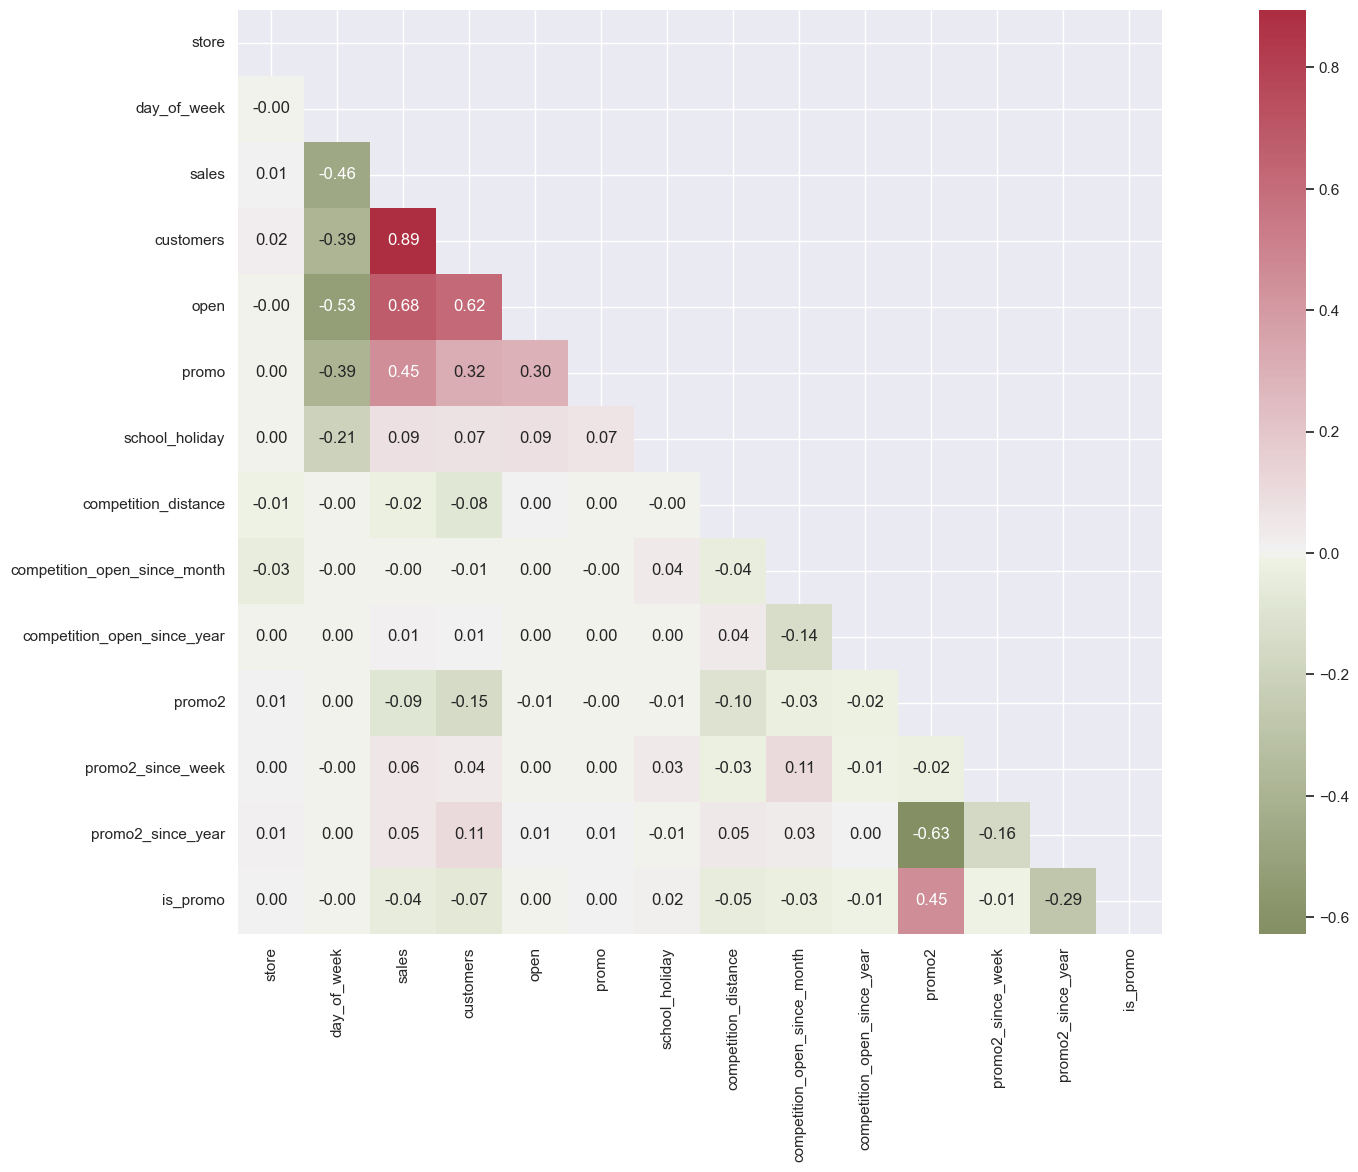

In [34]:
correlation = num_attributes.corr( method='pearson')
#sns.heatmap(correlation, annot=True);


mask = np.triu(np.ones_like(correlation, dtype=bool))
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)
sns.heatmap(correlation, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

## 4.3.2. Categorical Variable

<Axes: >

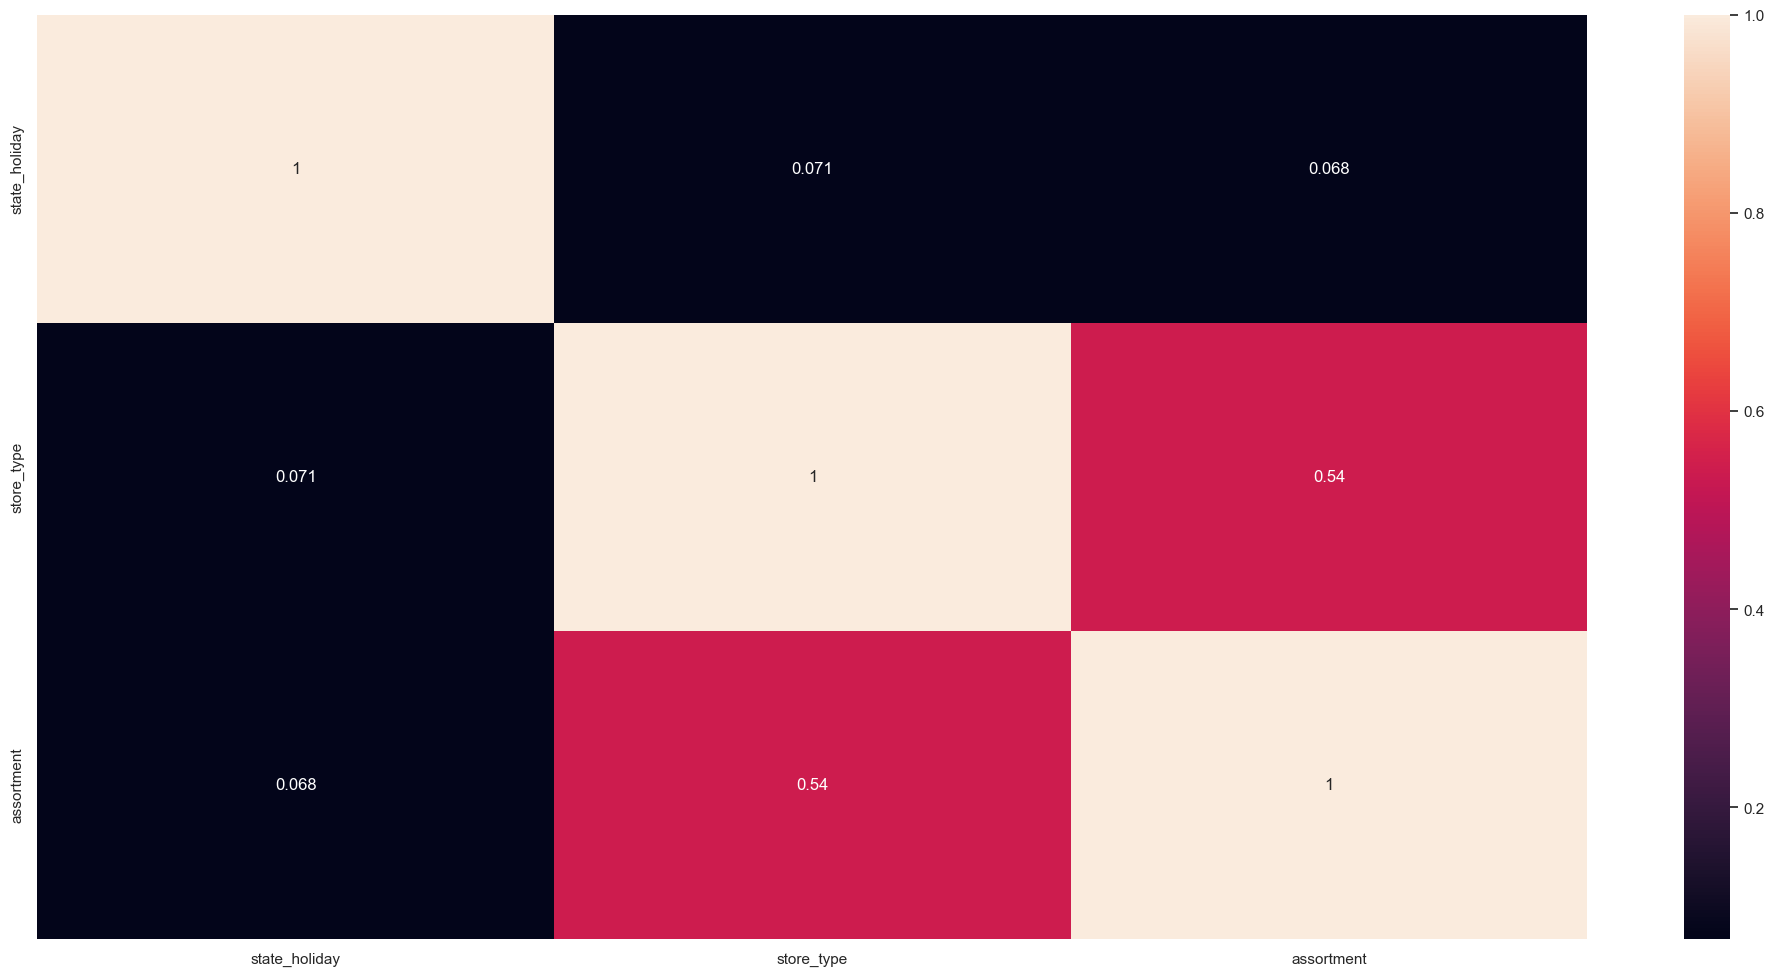

In [35]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0. Data preparation

In [36]:
df5 = df4.copy()

## 5.1. Normalizacao

## 5.2. Rescaling

In [37]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [38]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

pickle.dump( rs, open('C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\parameter\\competition_distance_scaler.pkl', 'wb'))

# competition time month

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

pickle.dump( rs, open('C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\parameter\\competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump( mms, open('C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\parameter\\promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump( mms, open('C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\parameter\\year_scaler.pkl', 'wb'))


## 5.3. Transformacao

### 4.3.1. Encoding

In [39]:
# state_holiday - One Hot Encoding

df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\parameter\\store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 4.3.2. Response Variable Transformation

In [40]:
df5['sales'] = np.log1p( df5['sales'] )

### 4.3.3. Nature Transformation

In [41]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7)))

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30)))

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52)))

In [42]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,day_sin,day_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,0.207912,0.978148,-0.5,-0.866025,-0.568065,-0.822984


# 6.0. Feature Selection

In [43]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [44]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']
# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.3. Botura as feture selector

In [61]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(␣X_train_n, y_train_n )

## 6.4. Best Features from Boruta

In [62]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )


## 6.5. Manual Feature Selection

In [45]:
cols_selected_boruta = [
'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_v2 = cols_selected_boruta.copy()
cols_selected_boruta_v2.extend( feat_to_add )
cols_selected_boruta_full = cols_selected_boruta_v2.copy()
#cols_selected_boruta.extend( feat_to_add )


# 7.0. Machine Learning Modelling

In [46]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]


# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [47]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result


,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [48]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [66]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr,verbose=False )
lr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2646.81 +/- 0.0,0.31 +/- 0.0,3821.9 +/- 0.0


## 7.3. Linear Regression Regularized Model - Lasso

In [54]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1. Lasso - Cross Validation

In [67]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2751.45 +/- 0.0,0.31 +/- 0.0,3976.15 +/- 0.0


## 7.4. Random Forest Regressor

In [57]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


### 7.4.1. Random Forest Regressor - Cross Validation

In [68]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv



KFold Number: 5


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1200.26 +/- 0.0,0.15 +/- 0.0,1772.77 +/- 0.0


## 7.5. XGBoost Regressor

In [64]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                            n_estimators=3000,
                            eta=0.01,
                            max_depth=10,
                            subsample=0.7,
                            colsample_bytree=0.9 ).fit( x_train, y_train )


# prediction

yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,642.275016,0.093069,943.339797


### 7.5.1. XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor',model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5


## 7.6. Compare Model’s Performance

### 7.6.1. Single Performance

In [65]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,642.275016,0.093069,943.339797
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2. Real Performance - Cross Validation

In [ ]:
##modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
##modelling_result_cv

# 8.0. Hyperparameter Fine Tuning

## 8.1. Random Search

In [ ]:
#param = {
# 'n_estimators': [1500, 1700, 2500, 3000, 3500],
# 'eta': [0.01, 0.03],
# 'max_depth': [3, 5, 9],
# 'subsample': [0.1, 0.5, 0.7],
# 'colsample_bytree': [0.3, 0.7, 0.9],
# 'min_child_weight': [3, 8, 15]
# }
#
#MAX_EVAL = 5

In [ ]:
#final_result = pd.DataFrame()
#
#for i in range( MAX_EVAL ):
# # choose values for parameters randomly
# hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
# print( hp )
#
# # model
# model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
# n_estimators=hp['n_estimators'],
# eta=hp['eta'],
# max_depth=hp['max_depth'],
# subsample=hp['subsample'],
# colsample_bytee=hp['colsample_bytree'],
# min_child_weight=hp['min_child_weight'] )
#
# # performance
# result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
# final_result = pd.concat( [final_result, result] )
#
#final_result

## 8.2. Final Model


In [66]:
param_tuned = {
'n_estimators': 3000,
'eta': 0.03,
'max_depth': 5,
'subsample': 0.7,
'colsample_bytree': 0.7,
'min_child_weight': 3
}

In [70]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
    n_estimators=param_tuned['n_estimators'],
    eta=param_tuned['eta'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytree=param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

    # prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,770.209978,0.115623,1108.062869


In [71]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.01598888634252212

# 9.0. Traducao e interpretacao do erro

In [72]:
df9 = X_test[ cols_selected_boruta_full ]
df10 = df9.copy()

# rescale
df10['sales'] = np.expm1( df10['sales'] )
df10['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1. Business Performance


In [73]:
# sum of predictions
df11 = df10[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df10_aux1 = df10[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df10_aux2 = df10[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df10_aux3 = pd.merge( df10_aux1, df10_aux2, how='inner', on='store' )
df10_2 = pd.merge( df11, df10_aux3, how='inner', on='store' )
#
## Scenarios
df10_2['worst_scenario'] = df10_2['predictions'] - df10_2['MAE']
df10_2['best_scenario'] = df10_2['predictions'] + df10_2['MAE']
#
## order columns
df10_2 = df10_2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [74]:
df10_2.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107259.992188,103900.995760,110618.988615,3358.996428,0.588526
908,909,218136.984375,210139.046769,226134.921981,7997.937606,0.523377
169,170,210068.781250,208498.057327,211639.505173,1570.723923,0.388486
901,902,202738.703125,201256.792243,204220.614007,1481.910882,0.369999
875,876,196581.156250,192483.555006,200678.757494,4097.601244,0.338941


<AxesSubplot:xlabel='store', ylabel='MAPE'>

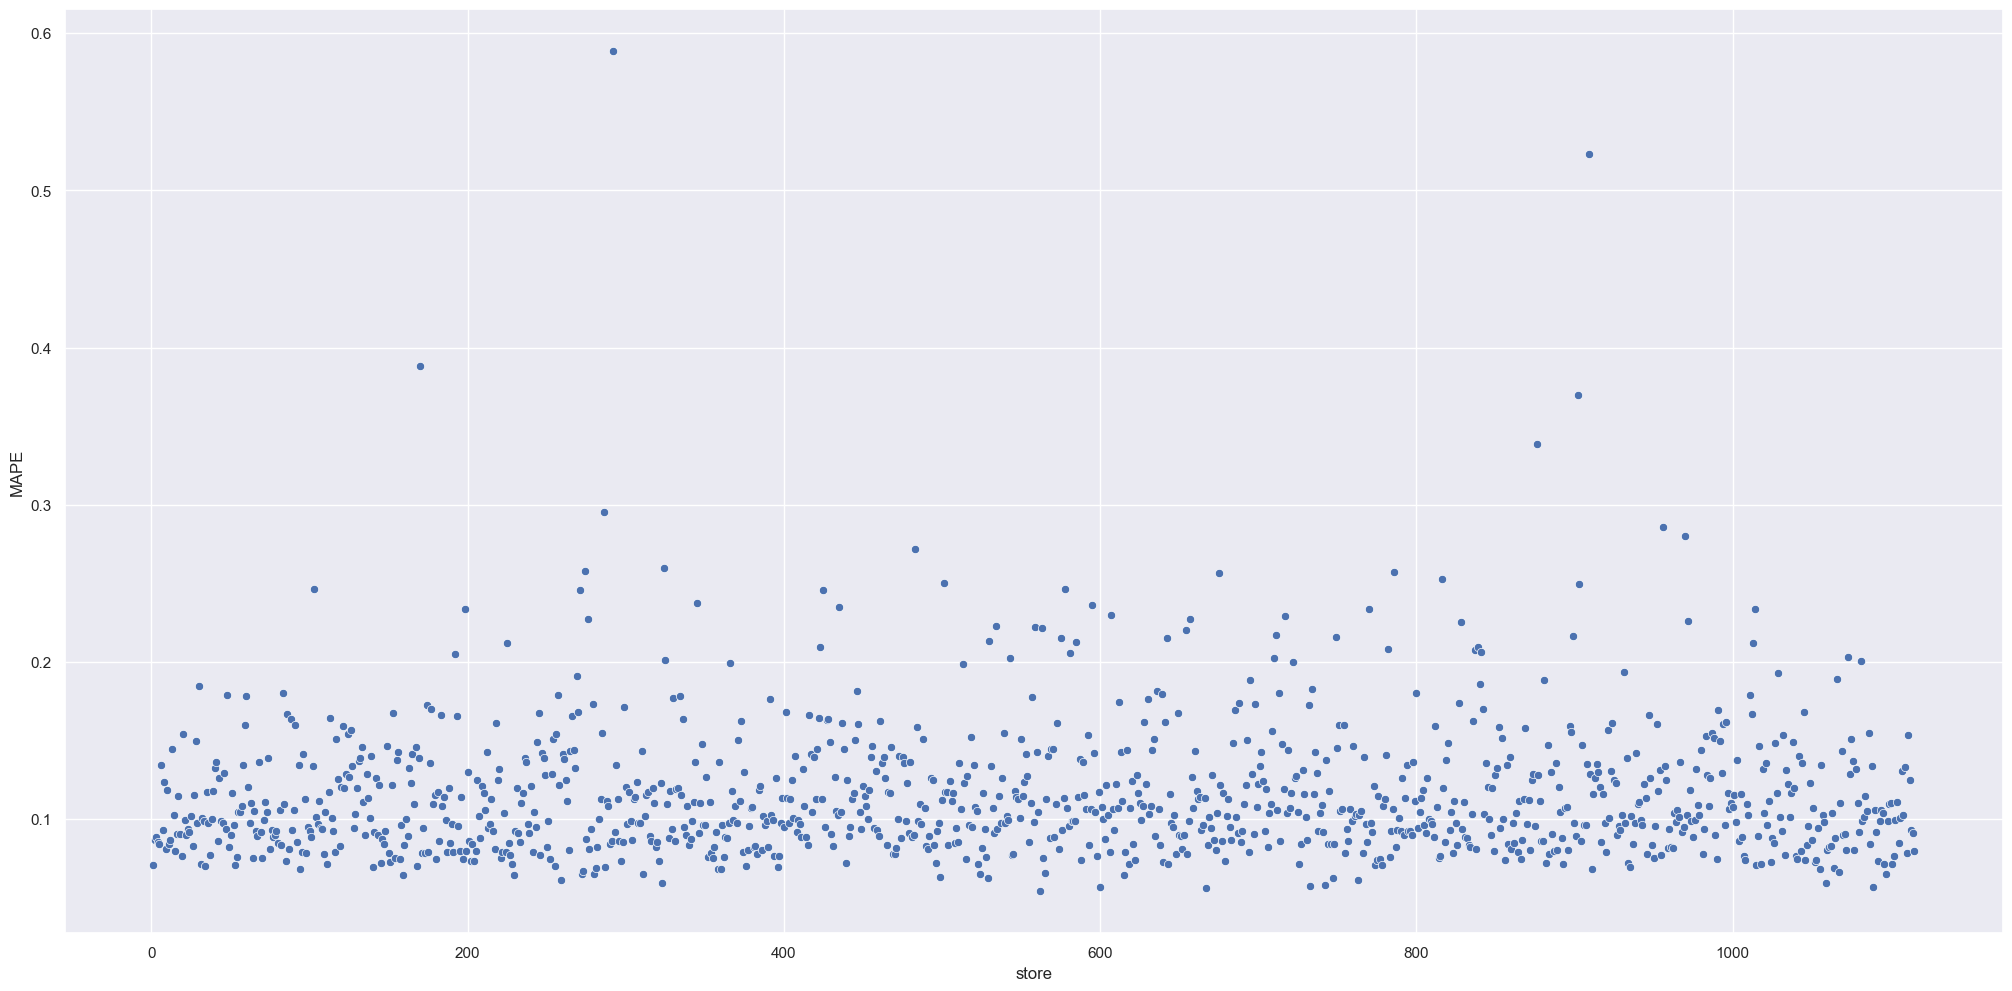

In [75]:
sns.scatterplot( x='store', y='MAPE', data=df10_2 )

## 9.2. Total Performance

In [76]:
df10_3 = df10_2[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x:np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df10_3['Values'] = df10_3['Values'].map( 'R${:,.2f}'.format )
df10_3


,Scenario,Values
0,predictions,"R$285,817,920.00"
1,worst_scenario,"R$284,955,855.77"
2,best_scenario,"R$286,679,971.85"


## 9.3. Machine Learning Performance

In [77]:
df10['error'] = df10['sales'] - df10['predictions']
df10['error_rate'] = df10['predictions'] / df10['sales']


C:\Users\nerod\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\nerod\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

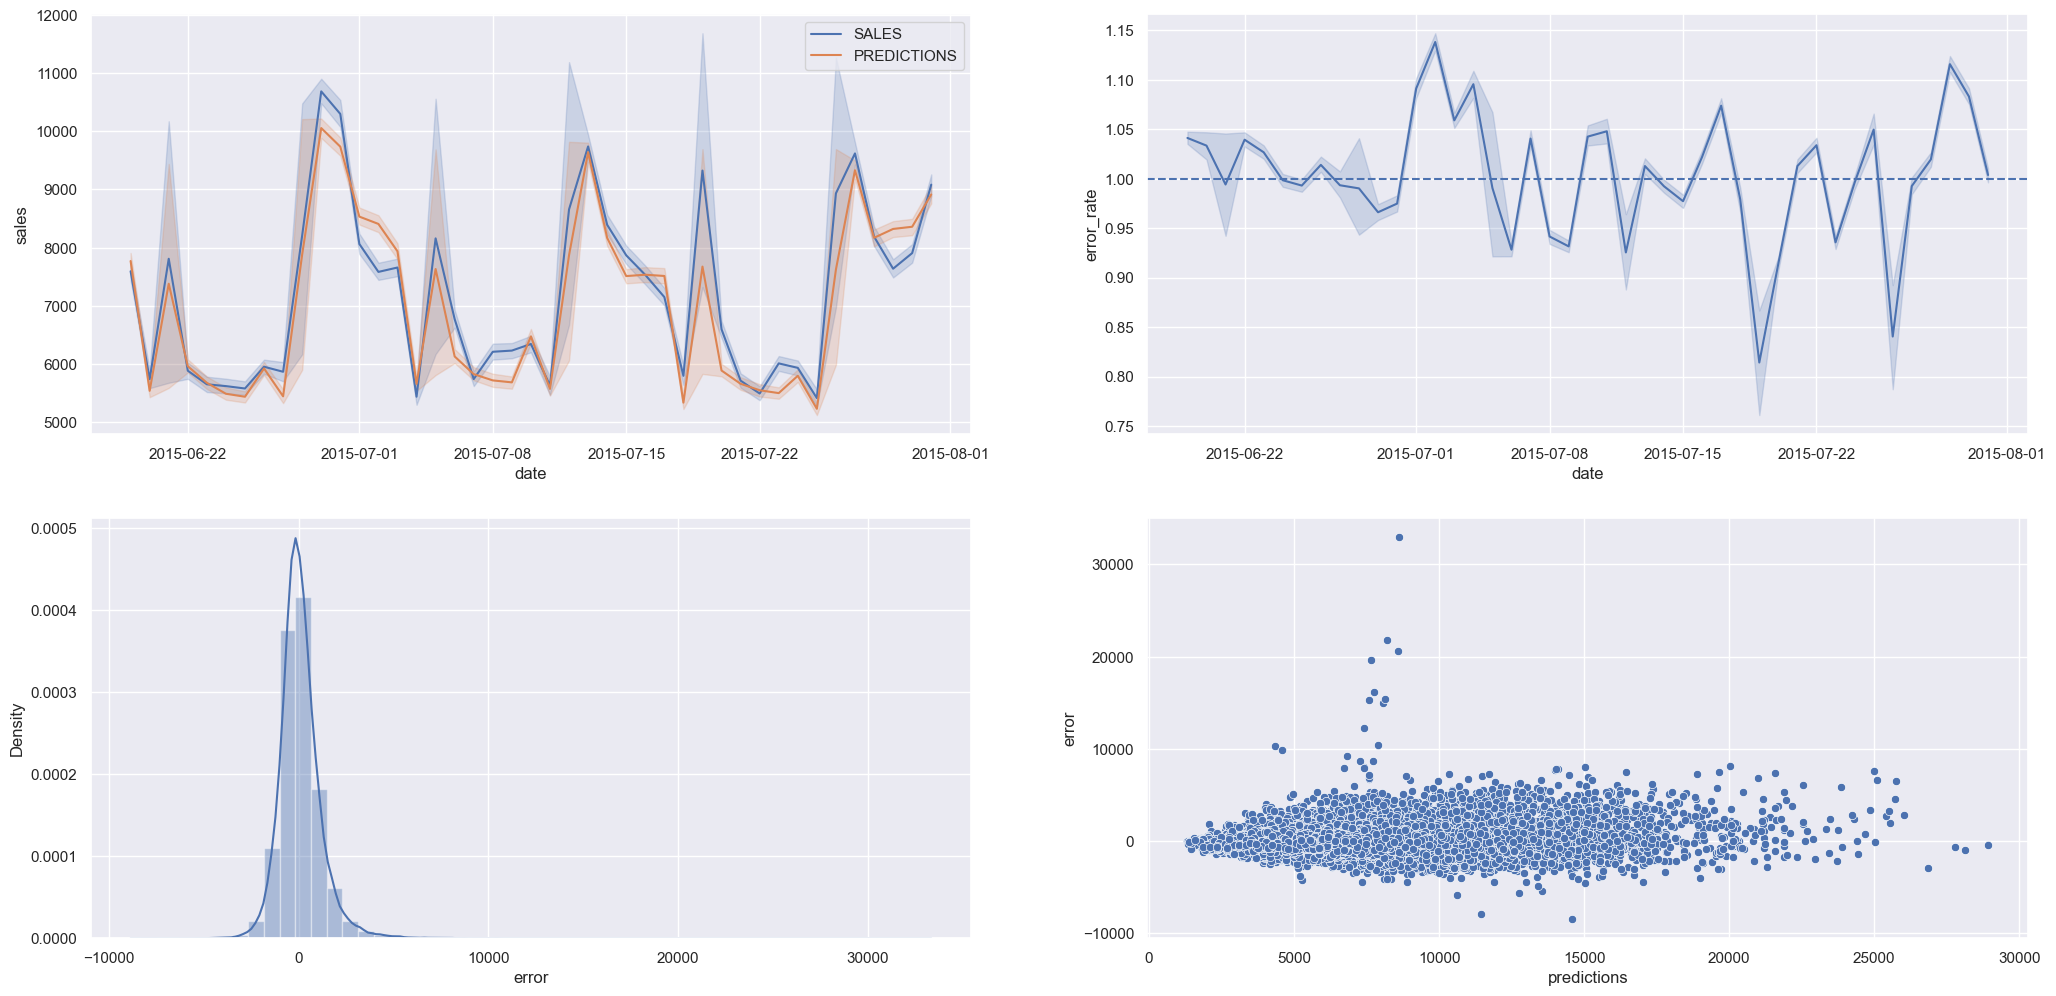

In [78]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df10, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df10, label='PREDICTIONS' )
plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df10 )
plt.axhline( 1, linestyle='--')
plt.subplot( 2, 2, 3 )
sns.distplot( df10['error'] )
plt.subplot( 2, 2, 4 )
sns.scatterplot( df10['predictions'], df10['error'] )


# 10.0. Deploy model to production

In [5]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open('C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\model_rossmann.pkl', 'wb'))

NameError: name 'model_xgb_tuned' is not defined

## 10.1. Rossman Class

In [10]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossmann( object ):
    
    def __init__(self):
        
        self.competition_distance_scaler   = pickle.load( open('C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\parameter\\competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load( open('C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\parameter\\competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load( open('C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\parameter\\promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load( open('C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\parameter\\year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load( open( 'C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\parameter\\store_type_scaler.pkl', 'rb') )
        
    
    def data_cleaning(self, df1):
        
        ## 1.1. Rename Columns
    
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore( x )
        
        cols_new = list( map(snakecase, cols_old) )
        
        df1.columns = cols_new
    
    
        ## 1.3. Data types
    
        df1['date'] = pd.to_datetime( df1['date'] )
    
    
        ## 1.5. Fillout NA
        
        #competition_distance
        
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan( x ) else x)
        
        
        #competition_open_since_month
        
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)
        
        #competition_open_since_year
        
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)
        
        #promo2  
        
        
        #promo2_since_week   
        
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)
        
        # promo2_since_year   
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)
        
        #promo_interval   
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace = True)
        
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        
        df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] 
                                                                    in x['promo_interval'].split(',') else 0, axis=1)
        
        
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )
        
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )
        
        return df1
    
    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        #df2['week_of_year'] = df2['date'].dt.weekofyear
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        
        
        
        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        #df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply (lambda x: x.days).astype(int)
        df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply (lambda x: x.days).astype(int)
        
        # promo since
        # Sanar dúvidas####
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)
               
        
        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x=='c' else 'regular_day')
        
        # 3.0. Filtragem de variáveis
        
        df3 = df2.copy()
        
        df3.head()
        
        ## 3.1. Filtragem das linhas
        
        df2 = df2[df2['open'] != 0]
        
        ## 3.2. Seleção das colunas
        
        cols_drop = [ 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2

    def data_preparation(self, df5):
        

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)


        # competition time month
        
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)




        ### 4.3.1. Encoding

        # state_holiday - One Hot Encoding

        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding

        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )


        ### 4.3.3. Nature Transformation
        
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2. * np.pi/7)))
        
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2. * np.pi/30)))
        
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2. * np.pi/12)))
        
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2. * np.pi/52)))
        
    
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year',
                            'promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos',
                            'month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data):
        #prediction
        pred = model.predict( test_data )
        
        #join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso')


## 10.2. API Handler

In [11]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\model_rossmann.pkl', 'rb') )
                          
# initialize API
app = Flask( __name__ )
@app.route( '/rossmann/predict', methods=['POST'] )
                          
def rossmann_predict():
    test_json = request.get_json()
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.data_preparation( df2 )
        # prediction

        df_response = pipeline.get_prediction( model, test_raw, df3 )
        return df_response

    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )


[22:57:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.100.7:5000
Press CTRL+C to quit


## 10.3. API Tester

In [26]:
import requests

In [27]:
df10 = pd.read_csv('C:\\Users\\nerod\\Repos\\DS\\DS_em_producao\\test.csv')

In [28]:
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20] )]
# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [29]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [30]:
# API Call
url = 'https://rossmann-api-q3f8.onrender.com/rossmann/predict'
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )


Status Code 200


In [23]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [31]:
d6 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [32]:
d6.head()


,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,20,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,d,basic,2340.0,...,2015,9,17,38,2015-37,2009-05-01T00:00:00.000,77,2014-09-29T00:00:00.000,50,7423.073730
1,20,3,2015-09-16T00:00:00.000,1.0,1,regular_day,0,d,basic,2340.0,...,2015,9,16,38,2015-37,2009-05-01T00:00:00.000,77,2014-09-29T00:00:00.000,50,7613.901855
2,20,2,2015-09-15T00:00:00.000,1.0,1,regular_day,0,d,basic,2340.0,...,2015,9,15,38,2015-37,2009-05-01T00:00:00.000,77,2014-09-29T00:00:00.000,50,8890.259766
3,20,1,2015-09-14T00:00:00.000,1.0,1,regular_day,1,d,basic,2340.0,...,2015,9,14,38,2015-37,2009-05-01T00:00:00.000,77,2014-09-29T00:00:00.000,50,9838.380859
4,20,6,2015-09-12T00:00:00.000,1.0,0,regular_day,0,d,basic,2340.0,...,2015,9,12,37,2015-36,2009-05-01T00:00:00.000,77,2014-09-29T00:00:00.000,49,4993.408203


In [25]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()
for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
    d2.loc[i, 'store'],
    d2.loc[i, 'prediction'] ) )

Store Number 20 will sell R$277,030.11 in the next 6 weeks
